In [27]:
import numpy as np
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import Workbook,load_workbook
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pingouin as pg
from statsmodels.stats.multitest import multipletests
import colorsys
import pingouin as pg
from scipy.stats import levene

save_path = 'xxxx'
res_path = 'xxxx'
load_path = 'xxxx'

# Parameters

In [2]:
day_info_dict = {13124:['_13124_d1', '_13124_d7', '_13124_d14', '_13124_d28', '_13124_d56'],
                 13141:['_13141_d1', '_13141_d7', '_13141_d14', '_13141_d21', '_13141_d28', '_13141_d56'],
                 13281:['_13281_d1', '_13281_d7', '_13281_d14', '_13281_d21', '_13281_d28']
                }

               
folder_info_dict = {13124:["reco_13124_d1_20241119_221734", "reco_13124_d7_20241126_211431", "reco_13124_d14_220140", \
                "13124_d28_20X_C2", "13124_d56_20X_C2"],
                   13141:["reco_13141_d1_203937", "reco_13141_d7_20241117_204240", "reco_13141_d14_20241123_194814", \
               "reco_13141_d21_20241130_225000", "reco_13141_d28_20241207_230148", "13141_d56_20X_C2"],
                    13281:["reco_13281_d1_195328", "reco_13281_d7_20241115_223348", "reco_13281_d14_20241121_191146", \
               "reco_13281_d21_20241129_213621", "reco_13281_d28_20241207_223245"]
                   }

x_days_dict = {13124:[1,7,14,28,56], 13141:[1,7,14,21,28,56], 13281:[1,7,14,21,28]}

# Methods

In [3]:
def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

def paired_test(list_1,list_2,path,alternative = 'two-sided'):
    # test and stats
    stats_data, stats_name = ["check"], ["check"]

    print(">> normality test")
    diff = [list_1[i] - list_2[i] for i in range(len(list_1))]
    pg_normality = pg.normality(diff).round(4)
    print(pg_normality)
    stats_data.extend(list(np.array(pg_normality)[0]))
    stats_name.extend(list(pg_normality))

    print(">> mean & std")
    mean, std = np.mean(diff).round(4), np.std(diff).round(4)
    print(mean,std)
    stats_data.extend([mean, std])
    stats_name.extend(["mean", "std"])

    print(">> parametric test")
    stats_data.append("param test")   
    stats_name.append("param test")   
    pg_ttest = pg.ttest(list_1, list_2, paired = True, alternative = alternative).round(4)
    print(pg_ttest)
    param_result = list(np.array(pg_ttest)[0])
    hg = pg.convert_effsize(param_result[5],'cohen','hedges',nx = len(list_1),ny = len(list_2))
    print('hedge-g')
    print(hg)
    stats_data.extend(param_result)
    stats_name.extend(list(pg_ttest))
    stats_data.append(hg)
    stats_name.append('hedges-d')

    print(">> non-parametric test")
    stats_data.append("non-param test")  
    stats_name.append("non-param test")  
    pg_wilcoxon = pg.wilcoxon(list_1, list_2, alternative = alternative).round(4)
    print(pg_wilcoxon)
    stats_data.extend(list(np.array(pg_wilcoxon)[0]))
    stats_name.extend(list(pg_wilcoxon))

    length = max(len(list_1), len(list_2), len(stats_data), len(stats_name))
    data = {"list_1": [list_1[i] if i < len(list_1) else "" for i in range(length)], 
            "list_2": [list_2[i] if i < len(list_2) else "" for i in range(length)], 
            "stats_name": [stats_name[i] if i < len(stats_name) else "" for i in range(length)],
            "stats_data": [stats_data[i] if i < len(stats_data) else "" for i in range(length)]}
    df = pd.DataFrame(data)
    df.to_csv(path)

def non_paired_test(list_1,list_2,path,alternative = 'two-sided'):
    list_1 = list(list_1)
    list_2 = list(list_2)
    stats_data, stats_name = ["check"], ["check"]

    # test and stats
    print(">> normality test")
    pg_normality = pg.normality(list_1).round(4)
    print(pg_normality)
    stats_data.extend(list(np.array(pg_normality)[0]))
    stats_name.extend(list(pg_normality))
    pg_normality = pg.normality(list_2).round(4)
    print(pg_normality)
    stats_data.extend(list(np.array(pg_normality)[0]))
    stats_name.extend(list(pg_normality))
    
    print(">> variance chi-square test")
    levene_s, levene_p = levene(list_1, list_2)
    print(levene_s, levene_p)
    print(">> mean & std")
    mean1, std1 = np.mean(list_1).round(4), np.std(list_1).round(4)
    mean2, std2 = np.mean(list_2).round(4), np.std(list_2).round(4)
    print("list_1:", mean1,std1)
    print("list_2:", mean2,std2)
    stats_data.extend([levene_s, levene_p, mean1, std1,mean2,std2])
    stats_name.extend(["levene_s", "levene_p", "mean1", "std1", "mean2", "std2"])

    print(">> parametric test")
    stats_data.append("param test")   
    stats_name.append("param test")   
    pg_ttest = pg.ttest(list_1, list_2, paired = False, alternative = alternative,correction = levene_p<0.05).round(4)
    print(pg_ttest)
    param_result = list(np.array(pg_ttest)[0])
    hg = pg.convert_effsize(param_result[5],'cohen','hedges',nx = len(list_1),ny = len(list_2))
    print('hedge-g')
    print(hg)
    stats_data.extend(param_result)
    stats_name.extend(list(pg_ttest))
    stats_data.append(hg)
    stats_name.append('hedges-d')

    print(">> non-parametric test")
    stats_data.append("non-param test")  
    stats_name.append("non-param test")  
    pg_mwu = pg.mwu(list_1, list_2, alternative = alternative).round(4)
    print(pg_mwu)
    stats_data.extend(list(np.array(pg_mwu)[0]))
    stats_name.extend(list(pg_mwu))

    length = max(len(list_1), len(list_2), len(stats_data), len(stats_name))
    data = {"list_1": [list_1[i] if i < len(list_1) else "" for i in range(length)], 
            "list_2": [list_2[i] if i < len(list_2) else "" for i in range(length)], 
            "stats_name": [stats_name[i] if i < len(stats_name) else "" for i in range(length)],
            "stats_data": [stats_data[i] if i < len(stats_data) else "" for i in range(length)]}
    df = pd.DataFrame(data)
    df.to_csv(path)
    
def distribution_test(list_1, list_2, path, alternative = 'two-sided', mode='auto'):
    list_1 = list(list_1)
    list_2 = list(list_2)
    stats_data, stats_name = ["check"], ["check"]

    # test and stats
    print(">> normality test")
    pg_normality = pg.normality(list_1).round(4)
    print(pg_normality)
    stats_data.extend(list(np.array(pg_normality)[0]))
    stats_name.extend(list(pg_normality))
    pg_normality = pg.normality(list_2).round(4)
    print(pg_normality)
    stats_data.extend(list(np.array(pg_normality)[0]))
    stats_name.extend(list(pg_normality))
    
    print(">> variance chi-square test")
    levene_s, levene_p = levene(list_1, list_2)
    print(levene_s, levene_p)
    print(">> mean & std")
    mean1, std1 = np.mean(list_1).round(4), np.std(list_1).round(4)
    mean2, std2 = np.mean(list_2).round(4), np.std(list_2).round(4)
    print("list_1:", mean1,std1)
    print("list_2:", mean2,std2)
    stats_data.extend([levene_s, levene_p, mean1, std1,mean2,std2])
    stats_name.extend(["levene_s", "levene_p", "mean1", "std1", "mean2", "std2"])

    print(">> non-parametric test")
    stats_data.append("non-param test")  
    stats_name.append("non-param test")  
    
    stat, p_vlaue = stats.ks_2samp(list_1, list_2, alternative=alternative, mode=mode)
    print("stat, p_vlaue:", stat, p_vlaue)
    stats_data.extend(list([round(stat,4), round(p_vlaue,4)]))
    stats_name.extend(list(["ks_stat", "p_vlaue"]))

    cohen_eff = pg.compute_effsize(list_1, list_2, paired=False, eftype='cohen').round(4)
    cles_eff = pg.compute_effsize(list_1, list_2, eftype='cles').round(4)
    hedges_eff = pg.convert_effsize(cohen_eff, 'cohen','hedges',nx = len(list_1), ny = len(list_2)).round(4)
    print("cohen_eff:", cohen_eff, " cles_eff:", cles_eff, " hedges_eff:", hedges_eff)
    stats_data.extend(list([cohen_eff, cles_eff, hedges_eff]))
    stats_name.extend(list(["cohen_eff", "cles_eff", "hedges_eff"]))

    length = max(len(list_1), len(list_2), len(stats_data), len(stats_name))
    data = {"list_1": [list_1[i] if i < len(list_1) else "" for i in range(length)], 
            "list_2": [list_2[i] if i < len(list_2) else "" for i in range(length)], 
            "stats_name": [stats_name[i] if i < len(stats_name) else "" for i in range(length)],
            "stats_data": [stats_data[i] if i < len(stats_data) else "" for i in range(length)]}
    df = pd.DataFrame(data)
    df.to_csv(path)
    

# 01 Trace and Map

whole_trace_ori: <class 'pandas.core.frame.DataFrame'> (11988, 5022)


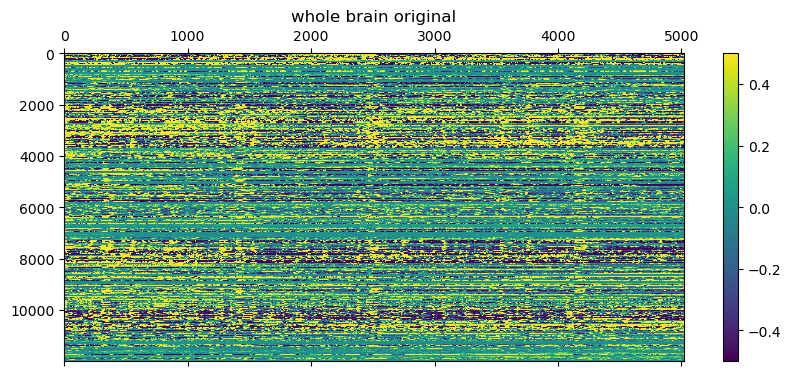

whole_center: <class 'pandas.core.frame.DataFrame'> (11988, 3)
neuron_x: <class 'numpy.ndarray'> (11988,) [ 95.    64.    89.5  239.5  217.86]
neuron_y: <class 'numpy.ndarray'> (11988,) [88.5   89.333 72.5   54.5   60.143]
neuron_z: <class 'numpy.ndarray'> (11988,) [30.  32.  31.5 37.5 34. ]


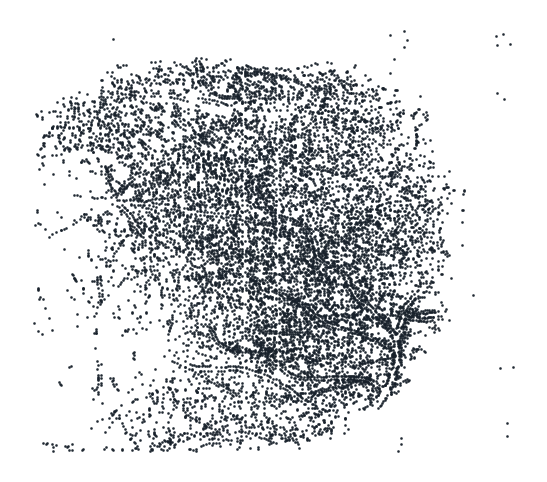

angle0_start_list: (24,) [ 969 1111 1433 1521 1567 1613 1759 1855 2474 2616]
angle45_start_list: (24,) [ 697  739  785  877 1253 1299 1391 1709 2202 2244]
angle90_start_list: (24,) [ 555  651  831 1019 1061 1345 1809 1901 2060 2156]
angle135_start_list: (24,) [ 509  605  923 1161 1211 1479 1663 1943 2014 2110]
norm_data: (11988, 850)


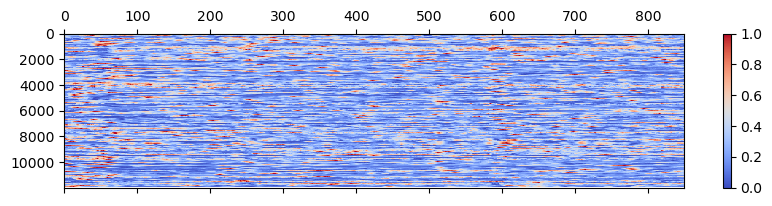

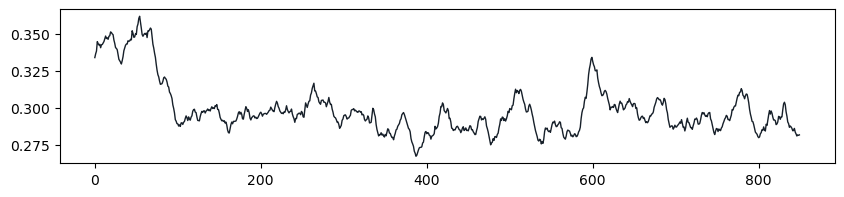

In [5]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

day_info = "_13124_d14"
load_path_map = 'F:/THU/post_craniotomy/data/13124/reco_13124_d14_220140/'

# load calc data
whole_trace_ori = pd.read_csv(load_path_map + "trace" + day_info + ".csv", header = None)
print("whole_trace_ori:", type(whole_trace_ori), whole_trace_ori.shape)
whole_trace_ori = whole_trace_ori.values

fig,ax = plt.subplots(figsize=(10,4), dpi=100, facecolor="w")
caxes = ax.matshow(whole_trace_ori, vmin = -0.5, vmax = 0.5, cmap = "viridis", aspect = "auto")
fig.colorbar(caxes)
plt.title("whole brain original")
plt.show()

# load original positions
whole_center = pd.read_csv(load_path_map + "pos" + day_info + ".csv", names = ["x", "y", "z"])
print("whole_center:", type(whole_center), whole_center.shape)
whole_center = whole_center.values
neuron_x = whole_center[:, 0].reshape(len(whole_center))
print("neuron_x:", type(neuron_x), neuron_x.shape, neuron_x[:5])
neuron_y = whole_center[:, 1].reshape(len(whole_center))
print("neuron_y:", type(neuron_y), neuron_y.shape, neuron_y[:5])
neuron_z = whole_center[:, 2].reshape(len(whole_center))
print("neuron_z:", type(neuron_z), neuron_z.shape, neuron_z[:5])

fig, ax = plt.subplots(figsize = (6.8, 6), dpi= 100,facecolor="w")
plt.scatter(neuron_x, neuron_y, s = 1, c = "#17202a", alpha = 0.8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.savefig(save_path + 'fig5_brain_map_all_neuron.pdf', dpi = 300, bbox_inches='tight')
plt.savefig(save_path + 'fig5_brain_map_all_neuron.png', dpi = 300, bbox_inches='tight')
plt.show()

# plot trace

res_path_map = 'F:/THU/post_craniotomy/results/13124/'
angle0_start_list = np.load(res_path_map + "angle0_calc_start_whole_stages" + day_info + ".npy").flatten()
angle45_start_list = np.load(res_path_map + "angle45_calc_start_whole_stages" + day_info + ".npy").flatten()
angle90_start_list = np.load(res_path_map + "angle90_calc_start_whole_stages" + day_info + ".npy").flatten()
angle135_start_list = np.load(res_path_map + "angle135_calc_start_whole_stages" + day_info + ".npy").flatten()
print("angle0_start_list:", angle0_start_list.shape, angle0_start_list[:10])
print("angle45_start_list:", angle45_start_list.shape, angle45_start_list[:10])
print("angle90_start_list:", angle90_start_list.shape, angle90_start_list[:10])
print("angle135_start_list:", angle135_start_list.shape, angle135_start_list[:10])
angle_dict = {0:angle0_start_list, 45:angle45_start_list, 90:angle90_start_list, 135:angle135_start_list}

stimu = 1
angle = 0
stimu_angle_start_list = angle_dict[angle]
stimu_concat_trace = whole_trace_ori[:, stimu_angle_start_list[stimu * 8] - 4 : stimu_angle_start_list[(stimu + 1) * 8 - 1] - 40]
norm_data = []
for i in stimu_concat_trace:
    norm_data.append(normalization(i))
norm_data = np.array(norm_data)
print("norm_data:", norm_data.shape)
fig,ax = plt.subplots(figsize=(10,2), dpi=100, facecolor="w")
caxes = ax.matshow(norm_data, vmin = 0, vmax = 1, cmap = "coolwarm", aspect = "auto")
fig.colorbar(caxes)
plt.savefig(save_path + 'fig5_trace_matrix_all_neuron.pdf', dpi = 300, bbox_inches='tight')
plt.show()

norm_data_avg = np.mean(norm_data, axis = 0)
fig,ax = plt.subplots(figsize=(10,2), dpi=100, facecolor="w")
plt.plot(norm_data_avg, linewidth = 1, color = "#17202a")
plt.savefig(save_path + 'fig5_trace_line_all_neuron.pdf', dpi = 300, bbox_inches='tight')
plt.show()



angle0_start_list: (24,) [ 969 1111 1433 1521 1567 1613 1759 1855 2474 2616]
angle45_start_list: (24,) [ 697  739  785  877 1253 1299 1391 1709 2202 2244]
angle90_start_list: (24,) [ 555  651  831 1019 1061 1345 1809 1901 2060 2156]
angle135_start_list: (24,) [ 509  605  923 1161 1211 1479 1663 1943 2014 2110]


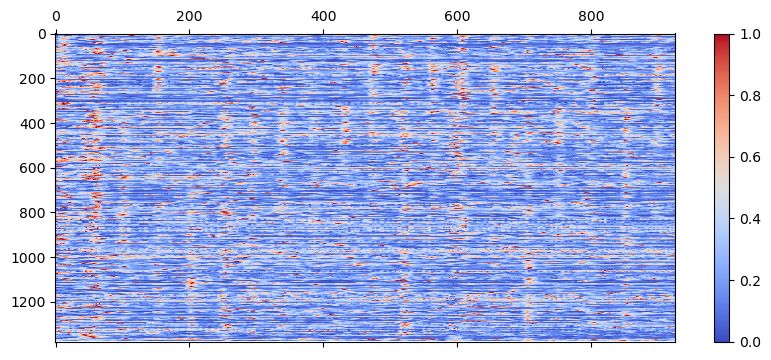

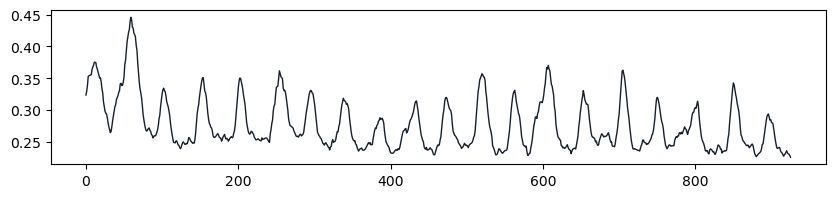

select_neuron_x: 1379 select_neuron_y: 1379
non_neuron_x: 10839 non_neuron_y: 10839


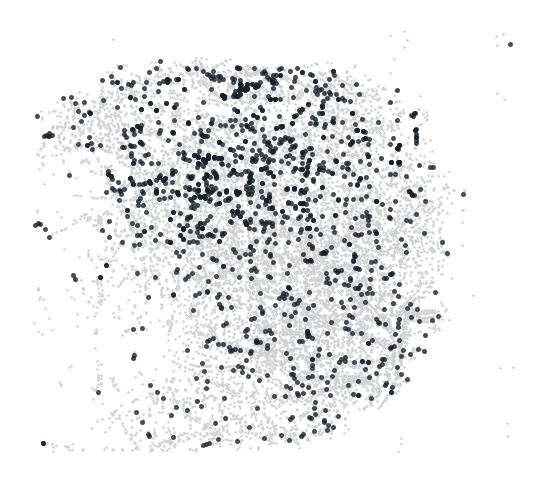

In [8]:
res_path_map = 'F:/THU/post_craniotomy/results/13124/'

angle0_start_list = np.load(res_path_map + "angle0_calc_start_whole_stages" + day_info + ".npy").flatten()
angle45_start_list = np.load(res_path_map + "angle45_calc_start_whole_stages" + day_info + ".npy").flatten()
angle90_start_list = np.load(res_path_map + "angle90_calc_start_whole_stages" + day_info + ".npy").flatten()
angle135_start_list = np.load(res_path_map + "angle135_calc_start_whole_stages" + day_info + ".npy").flatten()
print("angle0_start_list:", angle0_start_list.shape, angle0_start_list[:10])
print("angle45_start_list:", angle45_start_list.shape, angle45_start_list[:10])
print("angle90_start_list:", angle90_start_list.shape, angle90_start_list[:10])
print("angle135_start_list:", angle135_start_list.shape, angle135_start_list[:10])
angle_dict = {0:angle0_start_list, 45:angle45_start_list, 90:angle90_start_list, 135:angle135_start_list}

stimu = 1
angle = 0
duration = 8
color = "#17202a"

stimu_angle_start_list = angle_dict[angle]
stimu_start, stimu_end = stimu * 8, (stimu + 1) * 8 #8-16

select_data_ids_overlap_each = []
for angle in [0,45,90,135]:
    neu = np.load(res_path_map + "neurons/overlap_neurons_ids" + day_info + "_angle" + str(angle) + "_stimu" + str(stimu) + ".npy")
    select_data_ids_overlap_each.extend(neu)

    stimu_concat_trace = whole_trace_ori[neu, stimu_angle_start_list[stimu * 8] - 4 : stimu_angle_start_list[(stimu + 1) * 8 - 1] - 40]
    norm_data = []
    for i in stimu_concat_trace:
        norm_data.append(normalization(i))
    norm_data = np.array(norm_data)

stimu_concat_trace = whole_trace_ori[select_data_ids_overlap_each, stimu_angle_start_list[stimu * 8] - 4 : stimu_angle_start_list[(stimu + 1) * 8 - 1] + 36]
norm_data = []
for i in stimu_concat_trace:
    norm_data.append(normalization(i))
norm_data = np.array(norm_data)
fig,ax = plt.subplots(figsize=(10,4), dpi=100, facecolor="w")
caxes = ax.matshow(norm_data, vmin = 0, vmax = 1, cmap = "coolwarm", aspect = "auto")
fig.colorbar(caxes)
plt.savefig(save_path + 'fig5_trace_matrix_active_neuron.pdf', dpi = 300, bbox_inches='tight')
plt.show()

norm_data_avg = np.mean(norm_data, axis = 0)
fig,ax = plt.subplots(figsize=(10,2), dpi=100, facecolor="w")
plt.plot(norm_data_avg, linewidth = 1, color = "#17202a")
plt.savefig(save_path + 'fig5_trace_line_active_neuron.pdf', dpi = 300, bbox_inches='tight')
plt.show()


'''
plot map
'''
max_calc_size = 100
min_calc_size = 20
max_calc_color = 1.5

select_neuron_x, select_neuron_y = neuron_x[select_data_ids_overlap_each], neuron_y[select_data_ids_overlap_each]
print("select_neuron_x:", len(select_neuron_x), "select_neuron_y:", len(select_neuron_y))
non_select_data_ids = [i for i in range(len(whole_trace_ori)) if i not in select_data_ids_overlap_each]
non_neuron_x, non_neuron_y = neuron_x[non_select_data_ids], neuron_y[non_select_data_ids]
print("non_neuron_x:", len(non_neuron_x), "non_neuron_y:", len(non_neuron_y))

avg_trace = np.mean(whole_trace_ori[select_data_ids_overlap_each, stimu_angle_start_list[stimu_start] : stimu_angle_start_list[stimu_end - 1] + duration], axis = 1)
sizes = []
for i in avg_trace:
    if i * 50 > max_calc_size:
        sizes.append(max_calc_size)
    elif i * 50 < min_calc_size:
        sizes.append(min_calc_size)
    else:
        sizes.append(i * 50)
colors = [i if i < max_calc_color else max_calc_color for i in avg_trace]

fig, ax = plt.subplots(figsize = (6.8, 6), dpi= 100,facecolor="w")
plt.scatter(non_neuron_x, non_neuron_y, s = 1, c = "#ccd1d1", alpha = 0.8)
plt.scatter(select_neuron_x, select_neuron_y, s = 7, c = color, alpha = 0.7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.savefig(save_path + 'fig5_brain_map_active_neuron.pdf', dpi = 300, bbox_inches='tight')
plt.savefig(save_path + 'fig5_brain_map_active_neuron.png', dpi = 300, bbox_inches='tight')
plt.show()

# 02 All neurons

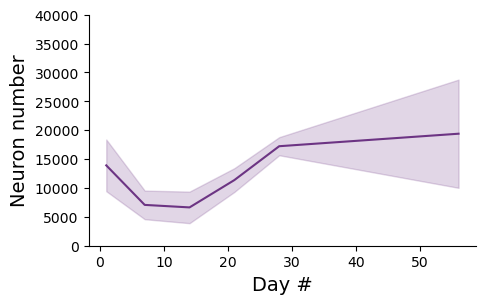

number_all_dict: {1: [9891, 22851, 9001], 7: [10999, 7714, 2495], 14: [11988, 4902, 3014], 21: [9312, 13424], 28: [16431, 20250, 15012], 56: [28762, 10028]}
------- d1 vs d7 --------
Wilcoxon stat: 1.0  p value: 0.5
------- d1 vs d14 --------
Wilcoxon stat: 1.0  p value: 0.5
------- d1 vs d21 --------
mannwhitneyu stat: 3.0  p value: 1.0
------- d1 vs d28 --------
Wilcoxon stat: 1.0  p value: 0.5
------- d1 vs d56 --------
mannwhitneyu stat: 1.0  p value: 0.4
------- d7 vs d14 --------
Wilcoxon stat: 3.0  p value: 1.0
------- d7 vs d21 --------
mannwhitneyu stat: 1.0  p value: 0.4
------- d7 vs d28 --------
Wilcoxon stat: 0.0  p value: 0.25
------- d7 vs d56 --------
mannwhitneyu stat: 1.0  p value: 0.4
------- d14 vs d21 --------
mannwhitneyu stat: 1.0  p value: 0.4
------- d14 vs d28 --------
Wilcoxon stat: 0.0  p value: 0.25
------- d14 vs d56 --------
mannwhitneyu stat: 1.0  p value: 0.4
------- d21 vs d28 --------
mannwhitneyu stat: 0.0  p value: 0.2
------- d21 vs d56 --------
Wi

In [11]:
mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]

intensity_avg_dict, number_all_dict = {}, {}
for day in day_selected:
    intensity_avg_dict[day] = []
    number_all_dict[day] = []

# load data
x_list, intensity_list, number_list = [], [], []
intensity_pair, number_pair = [], []
for mouse in mice_ids:
    day_info_list = day_info_dict[mouse]
    mouse_x, mouse_intensity, mouse_number = [], [], []
    for day_info in day_info_list:
        day = int(day_info.split('d')[1])
        if day not in day_selected:
            continue
        data = np.load(res_path + str(mouse) + "/res_global_number_intensity" + day_info + "_dict.npy", allow_pickle = True).item()
        intensity_avg_dict[day].append(data['intensity_avg'])
        number_all_dict[day].append(data['number_all'])
        mouse_x.append(day)
        mouse_intensity.append(data['intensity_avg'])
        mouse_number.append(data['number_all'])
        intensity_pair.append([day, data['intensity_avg']])
        number_pair.append([day, data['number_all']])
    x_list.append(mouse_x)
    intensity_list.append(mouse_intensity)
    number_list.append(mouse_number)

# avg
intensity_avg, number_avg = [], []
intensity_std, number_std = [], []
for day in day_selected:
    intensity_avg.append(np.mean(intensity_avg_dict[day]))
    intensity_std.append(np.std(intensity_avg_dict[day]))
    number_avg.append(np.mean(number_all_dict[day]))
    number_std.append(np.std(number_all_dict[day]))

# errorband plot
x, y = np.array(number_pair)[:,0], np.array(number_pair)[:,1]
plot_data = {"y": y, "x": x}
fig,ax = plt.subplots(figsize=(5,3),dpi=100,facecolor="w")
sns.lineplot(x = "x", y = "y", data = plot_data, color="#6c3483", err_style = "band", errorbar=('se', 1))
plt.xlabel("Day #", fontsize = 14)
plt.ylabel("Neuron number", fontsize = 14)
plt.ylim(0,40000)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
plt.savefig(save_path + 'fig5_number_all_neuron.pdf', dpi = 300, bbox_inches='tight')
plt.show()

## save data
data_save = [day_selected, number_avg, number_std]
np.save(save_path + 'fig5c_number_all_neuron_line.npy', data_save)
data_save = [x, y]
np.save(save_path + 'fig5c_number_all_neuron_scatter.npy', data_save)

data_csv = pd.DataFrame({"day":day_selected, "number_avg":number_avg, "number_std":number_std})
data_csv.to_csv(save_path + 'fig5c_number_all_neuron_line.csv', sep = ",")
data_csv = pd.DataFrame({"x":x, "y":y,})
data_csv.to_csv(save_path + 'fig5c_number_all_neuron_scatter.csv', sep = ",")


### test
print("number_all_dict:", number_all_dict)
p_list = []
for i in range(len(day_selected) - 1):
    pair1 = day_selected[i]
    for j in range(i + 1, len(day_selected)):
        pair2 = day_selected[j]
        
        print("------- d%d vs d%d --------" % (pair1, pair2))
        data1, data2 = number_all_dict[pair1], number_all_dict[pair2]
        if len(data1) ==  len(data2):
            stat, p_vlaue = stats.wilcoxon(data1, data2, alternative='two-sided', correction = True)
            print("Wilcoxon stat:", stat, " p value:", p_vlaue)
            p_list.append(p_vlaue)
        else:
            stat, p_vlaue = stats.mannwhitneyu(data1, data2, alternative='two-sided')
            print("mannwhitneyu stat:", stat, " p value:", p_vlaue)
            p_list.append(p_vlaue)

n = 3
print("---- p_list:", p_list)
ps = [round(i/n, 4) for i in p_list]
print("---- ps:", ps)
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("---- p_adj:", [round(i,4) for i in ps_adj])

# 03 Response number

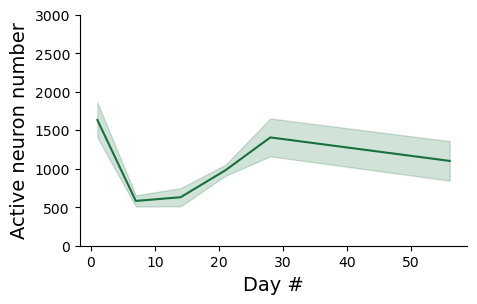

active_num_dict: {1: [array([1591, 1285, 1129]), array([2999, 2168, 2202]), array([1218, 1121,  984])], 7: [array([833, 849, 762]), array([539, 627, 610]), array([434, 349, 231])], 14: [array([1130, 1149,  986]), array([526, 430, 474]), array([312, 323, 341])], 21: [array([ 898,  926, 1004]), array([1318,  849,  888])], 28: [array([672, 709, 730]), array([2362, 2199, 2146]), array([1961,  789, 1092])], 56: [array([1734, 1755, 1378]), array([992, 366, 384])]}
active_num_dict_list: {1: [1591, 1285, 1129, 2999, 2168, 2202, 1218, 1121, 984], 7: [833, 849, 762, 539, 627, 610, 434, 349, 231], 14: [1130, 1149, 986, 526, 430, 474, 312, 323, 341], 21: [898, 926, 1004, 1318, 849, 888], 28: [672, 709, 730, 2362, 2199, 2146, 1961, 789, 1092], 56: [1734, 1755, 1378, 992, 366, 384]}
active_num_dict_cnt: [9, 9, 9, 6, 9, 6]
------- d1 vs d7 --------
Wilcoxon stat: 0.0  p value: 0.00390625
------- d1 vs d14 --------
Wilcoxon stat: 0.0  p value: 0.00390625
------- d1 vs d21 --------
mannwhitneyu stat: 4

In [12]:
mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]
mouse_colors = ["#76448a", "#1f618d", "#1e8449"]

''' stable neurons of all angles '''
active_num_dict = {}
for day in day_selected:
    active_num_dict[day] = []

# load data
active_num_pair = []
x_list, number_list, color_list = [], [], []
for mou_idx in range(len(mice_ids)):
    mouse = mice_ids[mou_idx]
    color = mouse_colors[mou_idx]
    day_info_list = day_info_dict[mouse]
    mouse_x, mouse_number = [], []
    for day_info in day_info_list:
        day = int(day_info.split('d')[1])
        if day not in day_selected:
            continue
        data = np.load(res_path + str(mouse) + "/res_response_number_overlap_angles_tog" + day_info + "_list.npy", allow_pickle = True)
        active_num_dict[day].append(data)
        for i in data:
            active_num_pair.append([day, i])
        mouse_x.append(day)
        mouse_number.append(data)
    x_list.append(mouse_x)
    number_list.append(mouse_number)
    color_list.append(color)

# avg
active_num_avg, active_num_std = [], []
for day in day_selected:
    active_num_avg.append(np.mean(active_num_dict[day]))
    active_num_std.append(np.std(active_num_dict[day]))

# errorband plot
x, y = np.array(active_num_pair)[:,0], np.array(active_num_pair)[:,1]
plot_data = {"y": y, "x": x}
fig,ax = plt.subplots(figsize=(5,3),dpi=100,facecolor="w")
sns.lineplot(x = "x", y = "y", data = plot_data, color="#196f3d", err_style = "band", errorbar=('se', 1))
plt.xlabel("Day #", fontsize = 14)
plt.ylabel("Active neuron number", fontsize = 14)
plt.ylim(0,3000)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
plt.savefig(save_path + 'fig5_number_active_neuron.pdf', dpi = 300, bbox_inches='tight')
plt.show()

## save data
data_save = [day_selected, active_num_avg, active_num_std]
np.save(save_path + 'fig5d_number_active_neuron_line.npy', data_save)
data_save = [x, y]
np.save(save_path + 'fig5d_number_active_neuron_scatter.npy', data_save)

data_csv = pd.DataFrame({"day":day_selected, "number_avg":active_num_avg, "number_std":active_num_std})
data_csv.to_csv(save_path + 'fig5d_number_active_neuron_line.csv', sep = ",")
data_csv = pd.DataFrame({"x":x, "y":y,})
data_csv.to_csv(save_path + 'fig5d_number_active_neuron_scatter.csv', sep = ",")

### test
print("active_num_dict:", active_num_dict)
active_num_dict_list, active_num_dict_cnt = {}, []
for i in day_selected:
    data = []
    for j in active_num_dict[i]:
        data.extend(list(j))
    active_num_dict_list[i] = data
    active_num_dict_cnt.append(len(data))
print("active_num_dict_list:", active_num_dict_list)
print("active_num_dict_cnt:", active_num_dict_cnt)

p_list = []
pairs = []
for i in range(len(day_selected) - 1):
    pair1 = day_selected[i]
    for j in range(i + 1, len(day_selected)):
        pair2 = day_selected[j]
        pairs.append((pair1, pair2))
        
        print("------- d%d vs d%d --------" % (pair1, pair2))
        data1, data2 = active_num_dict_list[pair1], active_num_dict_list[pair2]
        if len(data1) ==  len(data2):
            stat, p_vlaue = stats.wilcoxon(data1, data2, alternative='two-sided', correction = True)
            print("Wilcoxon stat:", stat, " p value:", p_vlaue)
            p_list.append(p_vlaue)
        else:
            stat, p_vlaue = stats.mannwhitneyu(data1, data2, alternative='two-sided')
            print("mannwhitneyu stat:", stat, " p value:", p_vlaue)
            p_list.append(p_vlaue)

n = 3
print("---- p_list:", p_list)
ps = [round(i/n, 4) for i in p_list]
print("---- ps:", ps)
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("---- p_adj:", [round(i,4) for i in ps_adj])
print("---- pairs:", pairs)

# 04 Response map

_13281_d28 pos_list: 4 ids_list: 1961 pos_ids_list: 4


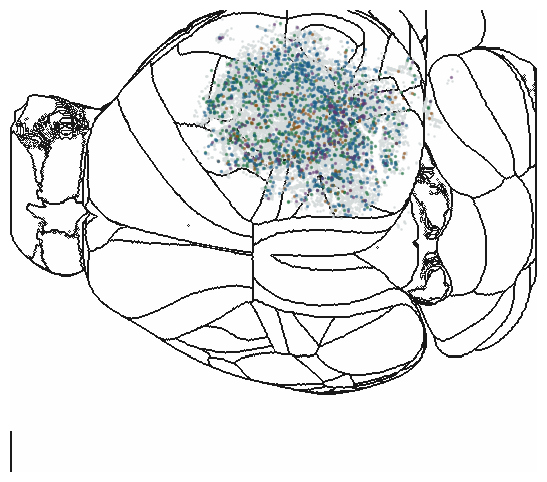

In [13]:
colors = ["#196F3D", "#935116", "#1F618D", "#633974"]
angle_names = ["angle 0", "angle 45", "angle 90", "angle 135"]

mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]
mouse_colors = ["#76448a", "#1f618d", "#1e8449"]


''' region map '''
active_num_dict = {}
for day in day_selected:
    active_num_dict[day] = []

x_list, number_list, color_list = [], [], []
for mou_idx in range(2,len(mice_ids)):
    mouse = mice_ids[mou_idx]
    color = mouse_colors[mou_idx]
    day_info_list = day_info_dict[mouse]
    folder_info = folder_info_dict[mouse]

    for d_idx in range(4,len(day_info_list)):
        day_info, folder = day_info_list[d_idx], folder_info[d_idx]
        day_name = day_info.split("_")[-1]

        # all pos
        whole_center = pd.read_csv(load_path + str(mouse) + "/" + folder +  "/pos" + day_info + ".csv", names = ["x", "y", "z"])
        whole_center = whole_center.values
        neuron_x = whole_center[:, 0].reshape(len(whole_center))
        neuron_y = whole_center[:, 1].reshape(len(whole_center))
        neuron_z = whole_center[:, 2].reshape(len(whole_center))

        # selected pos
        data = np.load(res_path + str(mouse) + "/res_response_pos_overlap_angles_sep" + day_info + "_dict.npy", allow_pickle = True).item()
        ids = np.load(res_path + str(mouse) + "/res_response_ids_overlap_angles_sep" + day_info + "_dict.npy", allow_pickle = True).item()
        pos_list, pos_ids_list, ids_list = [], [], []
        for angle in [0, 45, 90, 135]:
            pos_fla = []
            for data_i in data[angle][:1]:
                pos_fla.extend(data_i)
            pos_list.append(pos_fla)
            pos_ids_fla = []
            for ids_fla in ids[angle][:1]:
                ids_list.extend(ids_fla)
                pos_ids_fla.extend(ids_fla)
            pos_ids_list.append(pos_ids_fla)
        ids_list = list(set(ids_list))
        print(day_info, "pos_list:", len(pos_list), "ids_list:", len(ids_list), "pos_ids_list:", len(pos_ids_list))

        # plot
        non_select_data_ids = [i for i in range(len(neuron_x)) if i not in ids_list]
        non_neuron_x, non_neuron_y = neuron_x[non_select_data_ids], neuron_y[non_select_data_ids]

        # mapping
        CCF = pd.read_csv(load_path + str(mouse) + "/" + folder + '/CCF.csv', header = None)
        whole_center_2d_T = pd.read_csv(load_path + str(mouse) + "/" + folder +  '/whole_center_2d_T.csv', header = None)
        map_neuron_x, map_neuron_y = whole_center_2d_T.iloc[:,0], whole_center_2d_T.iloc[:,1]
        non_neuron_x, non_neuron_y = map_neuron_x[non_select_data_ids], map_neuron_y[non_select_data_ids]
        fig, ax = plt.subplots(figsize = (6.8, 6), dpi= 100,facecolor="w")
        ax = plt.subplot(1,1,1)
        sns.heatmap(CCF, vmin = -1, vmax = 1, cmap = "RdGy", cbar = False)
        plt.scatter(non_neuron_x, non_neuron_y, s = 0.8, c = "#D5DBDB", alpha = 0.8)
        for i in range(len(pos_ids_list)):
            select_neuron_x, select_neuron_y = map_neuron_x[pos_ids_list[i]], map_neuron_y[pos_ids_list[i]] 
            plt.scatter(select_neuron_x, select_neuron_y, s = 2, c = colors[i], alpha = 0.5)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.savefig(save_path + "fig5_neuron_dist_" + str(mouse) + "_" + day_name + ".pdf", dpi = 300, bbox_inches='tight')
        plt.savefig(save_path + "fig5_neuron_dist_" + str(mouse) + "_" + day_name + ".png", dpi = 300, bbox_inches='tight')
        plt.show()



# 05 Region-level connectivity 

In [15]:
colors = ["#196F3D", "#935116", "#1F618D", "#633974"]
angle_names = ["angle 0", "angle 45", "angle 90", "angle 135"]

mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]
mouse_colors = ["#76448a", "#1f618d", "#1e8449"]

''' region numbers '''
matrix, matrix_norm_region, matrix_norm_time = [], [], []
acs_all = []
for mou_idx in range(len(mice_ids)):
    print("=============== mou_idx ", mou_idx, " ====================")
    active_acs_set_all = []
    active_acs_set_list, active_acs_num_list = [], []
    
    mouse = mice_ids[mou_idx]
    day_info_list = day_info_dict[mouse]
    folder_info = folder_info_dict[mouse]

    for d_idx in range(len(day_info_list)):
        day_info, folder = day_info_list[d_idx], folder_info[d_idx]
        day = int(day_info.split('d')[1])
        if day not in day_selected:
            continue

        # selected pos
        ids = np.load(res_path + str(mouse) + "/res_response_ids_overlap_angles_sep" + day_info + "_dict.npy", allow_pickle = True).item()
        ids_list = []
        for angle in [0, 45, 90, 135]:
            for ids_fla in ids[angle][:1]:
                ids_list.extend(ids_fla)
        ids_list = list(set(ids_list))
        print(day_info, "ids_list:", len(ids_list))

        # mapping
        ids = pd.read_csv(load_path + str(mouse) + "/" + folder + '/ids.csv', header = None)
        ids = [int(i) for i in list(ids.iloc[:,0])]
        acs = pd.read_csv(load_path + str(mouse) + "/" + folder + '/acs.csv')
        acs = list(acs)
        acs = [i.split(".")[0] for i in acs]

        active_acs = list(np.array(acs)[ids_list])
        active_acs_set = list(set(active_acs))
        active_acs_num = []
        for i in active_acs_set:
            active_acs_num.append(active_acs.count(i))

        active_acs_set_list.append(active_acs_set)
        active_acs_num_list.append(active_acs_num)
        active_acs_set_all.extend(active_acs_set)


    active_acs_set_all = list(set(active_acs_set_all))
    active_acs_set_all.sort()
    print("active_acs_set_all:", len(active_acs_set_all))
    values_all = []
    for day_idx in range(len(active_acs_set_list)):
        active_acs_set = active_acs_set_list[day_idx]
        active_acs_num = active_acs_num_list[day_idx]
        values = []
        for i in active_acs_set_all:
            if i not in active_acs_set:
                values.append(0)
            else:
                idx = active_acs_set.index(i)
                values.append(active_acs_num[idx])
        values_all.append(values)
    print("values_all:", np.array(values_all).shape)
        
    # plot
    day_selected_name = ["D" + str(i) for i in day_selected]
    values_all_norm_region = []
    for i in values_all:
        values_all_norm_region.append(normalization(i))
    values_all_T = np.array(values_all).T
    values_all_norm = []
    for i in values_all_T:
        values_all_norm.append(normalization(i))
    values_all_norm = np.array(values_all_norm).T

    matrix.append(values_all)
    matrix_norm_region.append(values_all_norm_region) 
    matrix_norm_time.append(values_all_norm)
    acs_all.append(active_acs_set_all)
    


=============== mou_idx  0  ====================
_13124_d1 ids_list: 1591
_13124_d7 ids_list: 833
_13124_d14 ids_list: 1130
_13124_d28 ids_list: 672
_13124_d56 ids_list: 1734
active_acs_set_all: 42
values_all: (5, 42)
=============== mou_idx  1  ====================
_13141_d1 ids_list: 2999
_13141_d7 ids_list: 539
_13141_d14 ids_list: 526
_13141_d21 ids_list: 898
_13141_d28 ids_list: 2362
_13141_d56 ids_list: 992
active_acs_set_all: 32
values_all: (6, 32)
=============== mou_idx  2  ====================
_13281_d1 ids_list: 1218
_13281_d7 ids_list: 434
_13281_d14 ids_list: 312
_13281_d21 ids_list: 1318
_13281_d28 ids_list: 1961
active_acs_set_all: 37
values_all: (5, 37)


acs_all_overlap: 28


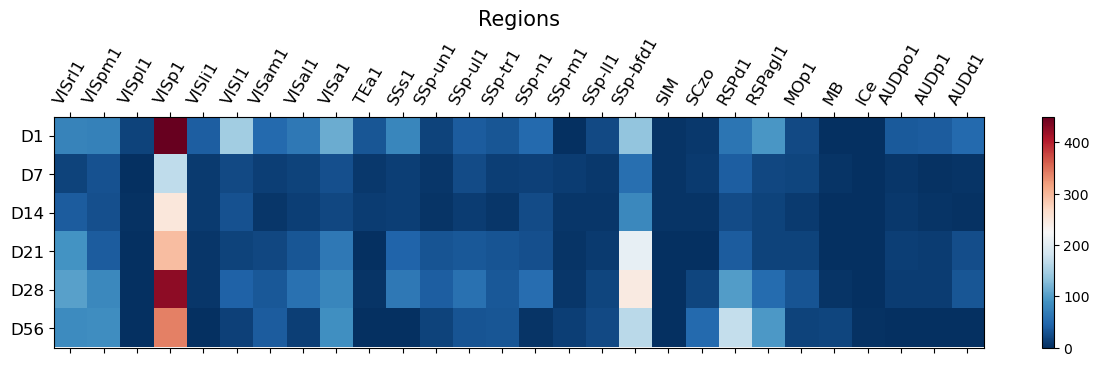

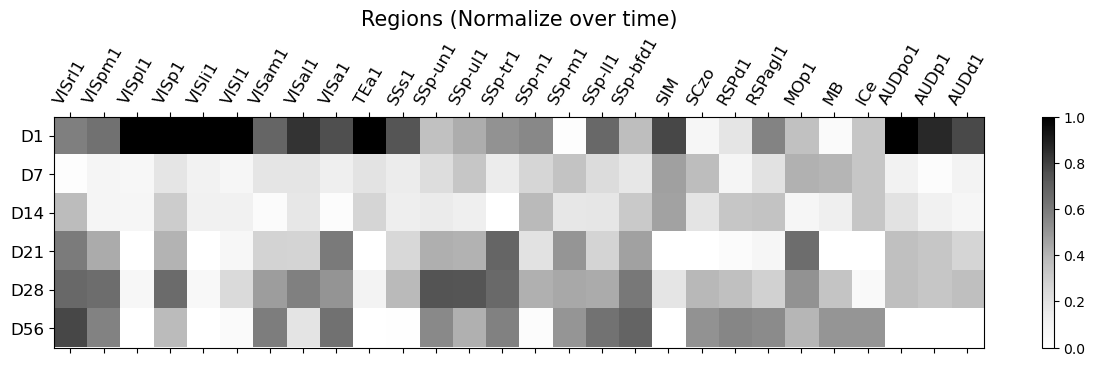

In [16]:
''' statistics '''

acs_all_overlap = []
for i in acs_all[0]:
    keep = True
    for j in range(1, len(acs_all)):
        if i not in acs_all[j]:
            keep = False
            break
    if keep:
        acs_all_overlap.append(i)
acs_all_overlap =  [i for i in acs_all_overlap if i not in ["root", "bic"]]
acs_all_overlap.sort()
acs_all_overlap.reverse()
print("acs_all_overlap:", len(acs_all_overlap))

# matrix
day_selected_name = ["D" + str(i) for i in day_selected]
matrix_new = np.zeros((len(day_selected_name), len(acs_all_overlap)))
for i in range(len(acs_all_overlap)):
    acs_i = acs_all_overlap[i]
    for j in range(len(acs_all)):
        idx = acs_all[j].index(acs_i)
        values = np.array(matrix[j])[:, idx]
        if j == 0 and len(values) == 5:
            values = list(values[:3]) + [0] + list(values[3:]) 
        matrix_new[:, i][:len(values)] += values
for i in range(len(matrix_new)):
    if i in [0,1,2,4]: # 1,7,14,28
        matrix_new[i] = matrix_new[i] / 3
    else:
        matrix_new[i] = matrix_new[i] / 2

fig,ax = plt.subplots(figsize=(15,3), dpi=100, facecolor="w")
caxes = ax.matshow(matrix_new, cmap = "RdBu_r", aspect = "auto", vmin = 0, vmax = 450)
fig.colorbar(caxes)
plt.xticks(range(len(acs_all_overlap)), acs_all_overlap, fontsize = 12, rotation = 60)
plt.yticks(range(len(day_selected_name)), day_selected_name, fontsize = 12)
plt.title("Regions", fontsize = 15)
plt.savefig(save_path + "fig5_neuron_dist_stats_number.pdf", dpi = 300, bbox_inches='tight')
plt.show()

# matrix time
day_selected_name = ["D" + str(i) for i in day_selected]
matrix_new = np.zeros((len(day_selected_name), len(acs_all_overlap)))
for i in range(len(acs_all_overlap)):
    acs_i = acs_all_overlap[i]
    for j in range(len(acs_all)):
        idx = acs_all[j].index(acs_i)
        values = np.array(matrix_norm_time[j])[:, idx]
        if j == 0 and len(values) == 5:
            values = list(values[:3]) + [0] + list(values[3:]) 
        matrix_new[:, i][:len(values)] += values
for i in range(len(matrix_new)):
    if i in [0,1,2,4]:
        matrix_new[i] = matrix_new[i] / 3
    else:
        matrix_new[i] = matrix_new[i] / 2
        
fig,ax = plt.subplots(figsize=(15,3), dpi=100, facecolor="w")
caxes = ax.matshow(matrix_new, cmap = "Greys", aspect = "auto")#, vmin = 0, vmax = 150)
fig.colorbar(caxes)
plt.xticks(range(len(acs_all_overlap)), acs_all_overlap, fontsize = 12, rotation = 60)
plt.yticks(range(len(day_selected_name)), day_selected_name, fontsize = 12)
plt.title("Regions (Normalize over time)", fontsize = 15)
plt.savefig(save_path + "fig5_neuron_dist_stats_norm_time.pdf", dpi = 300, bbox_inches='tight')
plt.show()

    


# 06 Manifold

In [17]:
''' collect data '''

mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]
n_stimu = 3
start, end = 450, 2700

# load data
for mouse in mice_ids:
    active_num_dict = {}
    for day in day_selected:
        active_num_dict[day] = []
    
    day_info_list = day_info_dict[mouse]    
    folder_info = folder_info_dict[mouse]

    for d_idx in range(len(day_info_list)):
        day_info, folder = day_info_list[d_idx], folder_info[d_idx]
        day = int(day_info.split('d')[1])
        if day not in day_selected:
            continue
            
        for angle in [0,45,90,135]:
            # neurons
            neuron_ids_list = []
            for stimu in range(n_stimu):  
                neuron_ids = np.load(res_path + str(mouse) + "/neurons/overlap_neurons_ids" + day_info + "_angle" + str(angle) + "_stimu" + str(stimu) + ".npy")
                neuron_ids_list.extend(neuron_ids)
            neuron_ids_list = list(set(neuron_ids_list))

            # trace concat
            whole_trace_ori = pd.read_csv(load_path + str(mouse) + "/" + folder +  "/trace" + day_info + ".csv", header = None)
            whole_trace_ori = whole_trace_ori.values
            time_trace = whole_trace_ori[neuron_ids_list, start:end]
            print(day_info, " -- angle:", angle, "time_trace:", time_trace.shape)
            active_num_dict[day].append(time_trace)
            
    print("mouse:", mouse, "active_num_dict:", len(active_num_dict))
    np.save(res_path + str(mouse) + "/res_day_angle_trace_concat_dict.npy", active_num_dict)

_13124_d1  -- angle: 0 time_trace: (1067, 2250)
_13124_d1  -- angle: 45 time_trace: (860, 2250)
_13124_d1  -- angle: 90 time_trace: (811, 2250)
_13124_d1  -- angle: 135 time_trace: (1142, 2250)
_13124_d7  -- angle: 0 time_trace: (629, 2250)
_13124_d7  -- angle: 45 time_trace: (597, 2250)
_13124_d7  -- angle: 90 time_trace: (506, 2250)
_13124_d7  -- angle: 135 time_trace: (706, 2250)
_13124_d14  -- angle: 0 time_trace: (876, 2250)
_13124_d14  -- angle: 45 time_trace: (671, 2250)
_13124_d14  -- angle: 90 time_trace: (761, 2250)
_13124_d14  -- angle: 135 time_trace: (831, 2250)
_13124_d28  -- angle: 0 time_trace: (545, 2250)
_13124_d28  -- angle: 45 time_trace: (507, 2250)
_13124_d28  -- angle: 90 time_trace: (497, 2250)
_13124_d28  -- angle: 135 time_trace: (600, 2250)
_13124_d56  -- angle: 0 time_trace: (1039, 2250)
_13124_d56  -- angle: 45 time_trace: (1166, 2250)
_13124_d56  -- angle: 90 time_trace: (1367, 2250)
_13124_d56  -- angle: 135 time_trace: (1319, 2250)
mouse: 13124 active_nu

labels: [0, 1, 2, 3]
X: (14714, 2250)
y: (14714,)


C:\Users\BBNC\AppData\Local\Temp\ipykernel_56012\1122688397.py:45: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


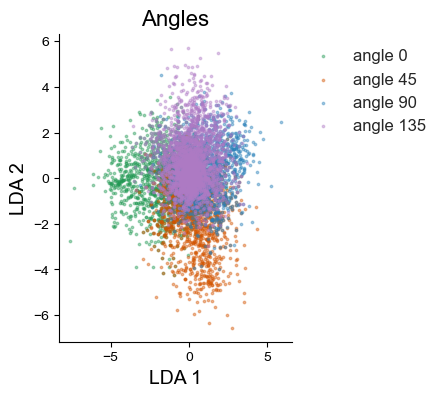

labels: [0, 1, 2, 3]
X: (5308, 2250)
y: (5308,)


C:\Users\BBNC\AppData\Local\Temp\ipykernel_56012\1122688397.py:45: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


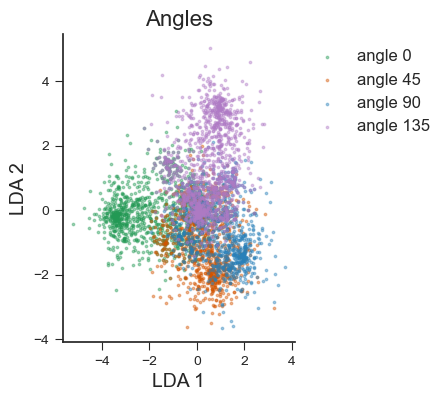

labels: [0, 1, 2, 3]
X: (5548, 2250)
y: (5548,)


C:\Users\BBNC\AppData\Local\Temp\ipykernel_56012\1122688397.py:45: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


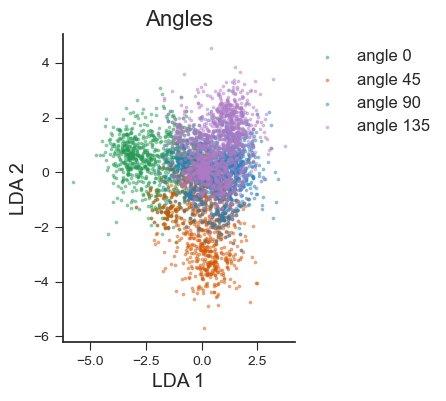

labels: [0, 1, 2, 3]
X: (5854, 2250)
y: (5854,)


C:\Users\BBNC\AppData\Local\Temp\ipykernel_56012\1122688397.py:45: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


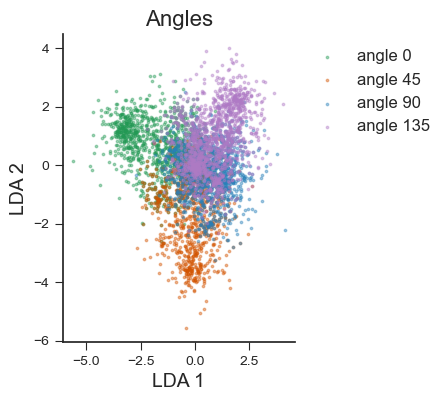

labels: [0, 1, 2, 3]
X: (12540, 2250)
y: (12540,)


C:\Users\BBNC\AppData\Local\Temp\ipykernel_56012\1122688397.py:45: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


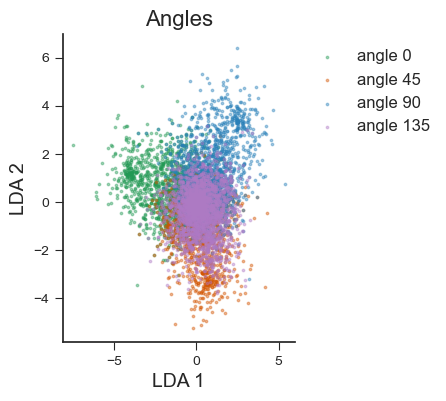

labels: [0, 1, 2, 3]
X: (6768, 2250)
y: (6768,)


C:\Users\BBNC\AppData\Local\Temp\ipykernel_56012\1122688397.py:45: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


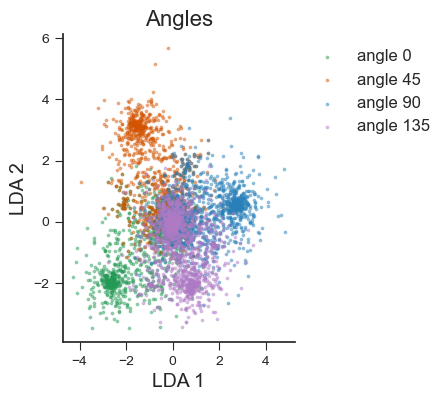

In [18]:
colors = ["#229954", "#d35400", "#2980b9", "#af7ac5"]
mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]
names = ["angle 0", "angle 45", "angle 90", "angle 135"]

# 5 days * 4 angle
group_cnt = 4
labels = range(group_cnt)

# load data
for day in day_selected:
    X, y = [], []
    for mouse in mice_ids:
        active_num_dict = np.load(res_path + str(mouse) + "/res_day_angle_trace_concat_dict.npy", allow_pickle = True).item()
        cnt = 0
        angles_trace = active_num_dict[day]
        for trace in angles_trace:
            X.extend(trace)
            y.extend([cnt] * len(trace))
            cnt += 1    
    print("labels:", list(set(y)))     
            
    ''' overall '''
    X = np.array(X)
    y = np.array(y)
    print("X:", X.shape)
    print("y:", y.shape)

    # LDA
    lda = LinearDiscriminantAnalysis(n_components = 3)
    lda.fit(X, y)
    X_new = lda.transform(X)
    fig, ax = plt.subplots(figsize = (3,4), dpi= 100,facecolor="w")
    plt.style.use('seaborn-ticks')
    for c, i, target_name in zip(colors, labels, names):
        plt.scatter(X_new[y == i, 0], X_new[y == i, 1], s = 3, c = c, label = target_name, alpha = 0.4)
    plt.xlabel('LDA 1', fontsize = 14)
    plt.ylabel('LDA 2', fontsize = 14)
    plt.title('Angles', fontsize = 16)
    for spine in ["top","right"]:
        ax.spines[spine].set_visible(False)
    plt.legend(fontsize = 12, bbox_to_anchor = (1,1))
    plt.savefig(save_path + "fig6_angle_lda_2dim_d" + str(day) + ".pdf", dpi = 300, bbox_inches='tight')
    plt.show()    

>> dist_list_days: 6


C:\Users\BBNC\AppData\Local\Temp\ipykernel_56012\4184466561.py:66: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


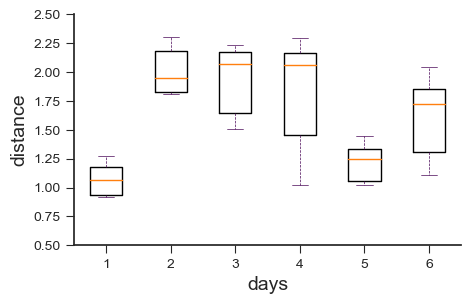

>>>>  0 1  -- Wilcoxon stat: 1.0  p value: 0.0625
>>>>  0 2  -- Wilcoxon stat: 0.0  p value: 0.03125
>>>>  0 3  -- Wilcoxon stat: 0.0  p value: 0.03125
>>>>  0 4  -- Wilcoxon stat: 6.0  p value: 0.4375
>>>>  0 5  -- Wilcoxon stat: 0.0  p value: 0.03125
>>>>  1 2  -- Wilcoxon stat: 10.0  p value: 1.0
>>>>  1 3  -- Wilcoxon stat: 10.0  p value: 1.0
>>>>  1 4  -- Wilcoxon stat: 2.0  p value: 0.09375
>>>>  1 5  -- Wilcoxon stat: 6.0  p value: 0.4375
>>>>  2 3  -- Wilcoxon stat: 10.0  p value: 1.0
>>>>  2 4  -- Wilcoxon stat: 2.0  p value: 0.09375
>>>>  2 5  -- Wilcoxon stat: 6.0  p value: 0.4375
>>>>  3 4  -- Wilcoxon stat: 2.0  p value: 0.09375
>>>>  3 5  -- Wilcoxon stat: 7.0  p value: 0.5625
>>>>  4 5  -- Wilcoxon stat: 0.0  p value: 0.03125
p_adj: [0.02929688 0.01953125 0.01953125 0.09943182 0.01953125 0.16666667
 0.16666667 0.02929688 0.09943182 0.16666667 0.02929688 0.09943182
 0.02929688 0.1171875  0.01953125]


In [19]:
colors = ["#229954", "#d35400", "#2980b9", "#af7ac5"]
mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]
names = ["angle 0", "angle 45", "angle 90", "angle 135"]

# 5 days * 4 angle
group_cnt = 4
labels = range(group_cnt)

# load data
dist_list_days = []
coverage_x_days, coverage_y_days = [], []
for day in day_selected:
    X, y = [], []
    for mouse in mice_ids:
        active_num_dict = np.load(res_path + str(mouse) + "/res_day_angle_trace_concat_dict.npy", allow_pickle = True).item()
        cnt = 0
        angles_trace = active_num_dict[day]
        for trace in angles_trace:
            X.extend(trace)
            y.extend([cnt] * len(trace))
            cnt += 1    
            
    ''' overall '''
    X = np.array(X)
    y = np.array(y)

    # LDA
    lda = LinearDiscriminantAnalysis(n_components = 3)
    lda.fit(X, y)
    X_new = lda.transform(X)
    
    labels_list = []
    center_position = []
    coverage_x, coverage_y = [], []
    for c, i, target_name in zip(colors, labels, names):
        x_pos, y_pos = X_new[y == i, 0], X_new[y == i, 1]
        xy_avg_pair = (round(np.mean(x_pos),3), round(np.mean(y_pos),3))
        labels_list.append(target_name)
        center_position.append(xy_avg_pair)
        coverage_x.append(round(np.std(x_pos),3))
        coverage_y.append(round(np.std(y_pos),3))
    coverage_x_days.append(coverage_x)
    coverage_y_days.append(coverage_y)
    
    dist_list = []
    for i in range(len(center_position) - 1):
        for j in range(i + 1, len(center_position)):
            pair1, pair2 = center_position[i], center_position[j]
            dist = np.sqrt((pair1[0] - pair2[0]) ** 2 + (pair1[1] - pair2[1]) ** 2)
            dist_list.append(dist)
    dist_list_days.append(dist_list)
    

print(">> dist_list_days:", len(dist_list_days))
x,y = [], []
avg, std = [], []
for i in range(len(dist_list_days)):
    y.extend(dist_list_days[i])
    x.extend([i + 1] * len(dist_list_days[i]))
    avg.append(np.median(dist_list_days[i]))
    std.append(np.std(dist_list_days[i]) / np.sqrt(len(mice_ids)))
plot_data = {"y": y, "x": x}

fig, ax = plt.subplots(figsize = (5,3), dpi= 100,facecolor="w")
plt.style.use('seaborn-ticks')
ax.boxplot(x=dist_list_days, vert=True, widths=0.5, showfliers=False, meanline=True,
    meanprops={'linestyle': '-', 'color': '#2980b9', 'linewidth': 0.5},
    whiskerprops={'linestyle': '--', 'linewidth': 0.5, 'color': '#480656'},
    capprops={ 'linestyle': '-', 'linewidth': 0.5, 'color': '#480656'})
plt.xlabel('days', fontsize = 14)
plt.ylabel('distance', fontsize = 14)
plt.ylim(0.5,2.5)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
plt.savefig(save_path + "fig6_angle_lda_2dim_distance.pdf", dpi = 300, bbox_inches='tight')
plt.show()

## test
ps_Bonferroni = []
for i in range(len(dist_list_days) - 1):
    for j in range(i + 1, len(dist_list_days)):
        stat, p_vlaue = stats.wilcoxon(dist_list_days[i], dist_list_days[j], alternative='two-sided', correction = True)
        print(">>>> ", i, j, " -- Wilcoxon stat:", stat, " p value:", p_vlaue)
        ps_Bonferroni.append(p_vlaue)
        
n = 6
ps = [i/n for i in ps_Bonferroni]
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("p_adj:", ps_adj)    

# 07 Functional connecivity

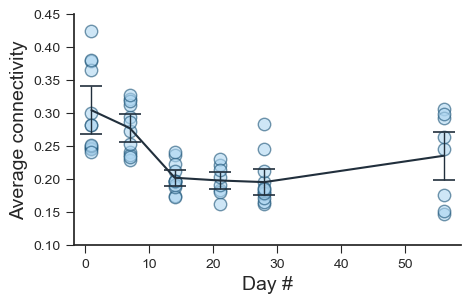

------- d1 vs d7 --------
Wilcoxon stat: 25.0  p value: 0.30126953125
------- d1 vs d14 --------
Wilcoxon stat: 0.0  p value: 0.00048828125
------- d1 vs d21 --------
mannwhitneyu stat: 96.0  p value: 0.000246293970482502
------- d1 vs d28 --------
Wilcoxon stat: 1.0  p value: 0.0009765625
------- d1 vs d56 --------
mannwhitneyu stat: 67.5  p value: 0.142380071662071
------- d7 vs d14 --------
Wilcoxon stat: 1.0  p value: 0.0009765625
------- d7 vs d21 --------
mannwhitneyu stat: 95.0  p value: 3.175359212510915e-05
------- d7 vs d28 --------
Wilcoxon stat: 0.0  p value: 0.00048828125
------- d7 vs d56 --------
mannwhitneyu stat: 64.0  p value: 0.23797729618163055
------- d14 vs d21 --------
mannwhitneyu stat: 53.0  p value: 0.7283560871056942
------- d14 vs d28 --------
Wilcoxon stat: 19.0  p value: 0.4148230671847747
------- d14 vs d56 --------
mannwhitneyu stat: 34.0  p value: 0.2974397791804603
------- d21 vs d28 --------
mannwhitneyu stat: 58.5  p value: 0.44022877044555897
------

In [20]:
mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]

''' avgerage correlation '''

active_num_dict = {}
for day in day_selected:
    active_num_dict[day] = []

# load data
active_num_pair = []
for mouse in mice_ids:
    day_info_list = day_info_dict[mouse]
    for day_info in day_info_list:
        day = int(day_info.split('d')[1])
        if day not in day_selected:
            continue
        data = np.load(res_path + str(mouse) + "/res_angle_stable_neurons_corr_matrix_stat" + day_info + "_dict.npy", allow_pickle = True).item()
        active_num_dict[day].append(data["corr_avg"])
        for i in data["corr_avg"]:
            active_num_pair.append([day, i])

# avg
active_num_avg, active_num_std = [], []
for day in day_selected:
    active_num_avg.append(np.mean(active_num_dict[day]))
    active_num_std.append(np.std(active_num_dict[day]))
    
# scatter plot
x, y = np.array(active_num_pair)[:,0], np.array(active_num_pair)[:,1]
fig,ax = plt.subplots(figsize=(5,3),dpi=100,facecolor="w")
active_num_std = [i / np.sqrt(len(mice_ids)) for i in active_num_std]
plt.errorbar(day_selected, active_num_avg, yerr = active_num_std, fmt = '-', ecolor = "#212f3c",  elinewidth = 1, 
        capthick = 1.2, color = "#212f3c", capsize = 8, ms = 8, mfc = 'w', alpha = 1)
plt.scatter(x, y, s = 80, c = "#aed6f1", edgecolors = "#1a5276", alpha = 0.6, linewidths = 1)
plt.xlabel("Day #", fontsize = 14)
plt.ylabel("Average connectivity", fontsize = 14)
plt.ylim(0.1,0.45)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
plt.savefig(save_path + "fig6_corr_avg.pdf", dpi = 300, bbox_inches='tight')
plt.show()

## save data
data_save = [day_selected, active_num_avg, active_num_std]
np.save(save_path + 'fig6d_corr_avg_line.npy', data_save)
data_save = [x, y]
np.save(save_path + 'fig6d_corr_avg_scatter.npy', data_save)

data_csv = pd.DataFrame({"day":day_selected, "avg":active_num_avg, "std":active_num_std})
data_csv.to_csv(save_path + 'fig6d_corr_avg_line.csv', sep = ",")
data_csv = pd.DataFrame({"x":x, "y":y,})
data_csv.to_csv(save_path + 'fig6d_corr_avg_scatter.csv', sep = ",")


### test
active_num_dict_list, active_num_dict_cnt = {}, []
for i in day_selected:
    data = []
    for j in active_num_dict[i]:
        data.extend(list(j))
    active_num_dict_list[i] = data
    active_num_dict_cnt.append(len(data))

p_list = []
pairs = []
for i in range(len(day_selected) - 1):
    pair1 = day_selected[i]
    for j in range(i + 1, len(day_selected)):
        pair2 = day_selected[j]
        pairs.append((pair1, pair2))
        
        print("------- d%d vs d%d --------" % (pair1, pair2))
        data1, data2 = active_num_dict_list[pair1], active_num_dict_list[pair2]
        if len(data1) ==  len(data2):
            stat, p_vlaue = stats.wilcoxon(data1, data2, alternative='two-sided', correction = True)
            print("Wilcoxon stat:", stat, " p value:", p_vlaue)
            p_list.append(p_vlaue)
        else:
            stat, p_vlaue = stats.mannwhitneyu(data1, data2, alternative='two-sided')
            print("mannwhitneyu stat:", stat, " p value:", p_vlaue)
            p_list.append(p_vlaue)

n = 3
print("---- p_list:", p_list)
ps = [round(i/n, 4) for i in p_list]
print("---- ps:", ps)
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("---- p_adj:", [round(i,4) for i in ps_adj])
print("---- pairs:", pairs)

C:\Users\BBNC\AppData\Local\Temp\ipykernel_45584\2498485693.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(len(day_selected), 1, i + 1)
D:\Program_Files\anaconda3\lib\site-packages\matplotlib\image.py:175: UserWarning: Data with more than 2**23 columns cannot be accurately displayed. Downsampling to less than 2**23 columns before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**23 columns'))


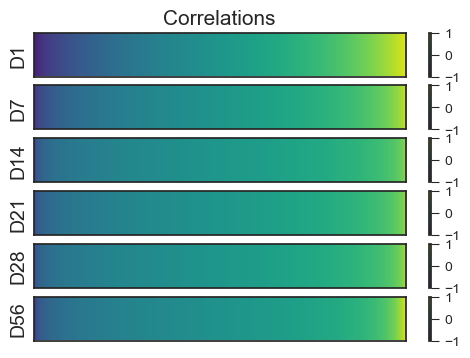

In [68]:
mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]

''' correlation list '''

active_num_dict = {}
for day in day_selected:
    active_num_dict[day] = []

# load data
for mouse in mice_ids:
    day_info_list = day_info_dict[mouse]
    for day_info in day_info_list:
        day = int(day_info.split('d')[1])
        if day not in day_selected:
            continue
        day_data = []
        data = np.load(res_path + str(mouse) + "/res_angle_stable_neurons_corr_list" + day_info + "_dict.npy", allow_pickle = True).item()
        for angle in [0, 45, 90, 135]:
            day_data.extend(data[angle])
        active_num_dict[day].extend(day_data)

fig,ax = plt.subplots(figsize=(6,4),dpi=100,facecolor="w")
for i in range(len(day_selected)):
    ax = plt.subplot(len(day_selected), 1, i + 1)
    matrix_plot = active_num_dict[day_selected[i]]
    matrix_plot.sort()
    matrix_plot = np.array(matrix_plot).reshape((1, len(matrix_plot)))
    caxes = ax.matshow(matrix_plot, interpolation ='nearest', cmap = "viridis", aspect = 'auto', vmin = -1, vmax = 1) 
    fig.colorbar(caxes) 
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("D" + str(day_selected[i]), fontsize = 14)
    if i == 0:
        plt.title("Correlations", fontsize = 15)
plt.savefig(save_path + "fig6_corr_list.pdf", dpi = 300, bbox_inches='tight')
plt.show()

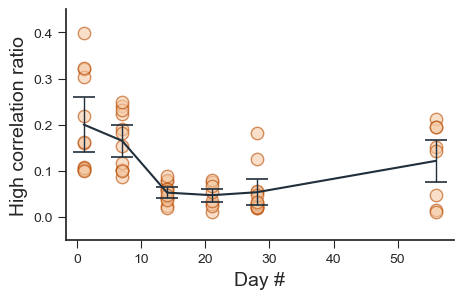

------- d1 vs d7 --------
Wilcoxon stat: 27.0  p value: 0.38037109375
------- d1 vs d14 --------
Wilcoxon stat: 0.0  p value: 0.00048828125
------- d1 vs d21 --------
mannwhitneyu stat: 96.0  p value: 0.000246293970482502
------- d1 vs d28 --------
Wilcoxon stat: 4.0  p value: 0.00341796875
------- d1 vs d56 --------
mannwhitneyu stat: 65.0  p value: 0.20284724043238278
------- d7 vs d14 --------
Wilcoxon stat: 0.0  p value: 0.00048828125
------- d7 vs d21 --------
mannwhitneyu stat: 96.0  p value: 1.5876796062554575e-05
------- d7 vs d28 --------
Wilcoxon stat: 0.0  p value: 0.00048828125
------- d7 vs d56 --------
mannwhitneyu stat: 62.0  p value: 0.3053901722632373
------- d14 vs d21 --------
mannwhitneyu stat: 55.5  p value: 0.5888741547561036
------- d14 vs d28 --------
Wilcoxon stat: 37.0  p value: 0.90966796875
------- d14 vs d56 --------
mannwhitneyu stat: 31.0  p value: 0.20284724043238278
------- d21 vs d28 --------
mannwhitneyu stat: 53.5  p value: 0.6995681542011702
-------

In [21]:
mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]

''' high correlation ratio '''

active_num_dict = {}
for day in day_selected:
    active_num_dict[day] = []

# load data
active_num_pair = []
for mouse in mice_ids:
    day_info_list = day_info_dict[mouse]
    for day_info in day_info_list:
        day = int(day_info.split('d')[1])
        if day not in day_selected:
            continue
        data = np.load(res_path + str(mouse) + "/res_angle_stable_neurons_corr_matrix_stat" + day_info + "_dict.npy", allow_pickle = True).item()
        active_num_dict[day].append(data["corr_large_ratio"])
        for i in data["corr_large_ratio"]:
            active_num_pair.append([day, i])

# avg
active_num_avg, active_num_std = [], []
for day in day_selected:
    active_num_avg.append(np.mean(active_num_dict[day]))
    active_num_std.append(np.std(active_num_dict[day]))
    
# scatter plot
x, y = np.array(active_num_pair)[:,0], np.array(active_num_pair)[:,1]
fig,ax = plt.subplots(figsize=(5,3),dpi=100,facecolor="w")
active_num_std = [i / np.sqrt(len(mice_ids)) for i in active_num_std]
plt.errorbar(day_selected, active_num_avg, yerr = active_num_std, fmt = '-', ecolor = "#212f3c",  elinewidth = 1, 
        capthick = 1.2, color = "#212f3c", capsize = 8, ms = 8, mfc = 'w', alpha = 1)
plt.scatter(x, y, s = 80, c = "#f5cba7", edgecolors = "#ba4a00", alpha = 0.6, linewidths = 1)
plt.xlabel("Day #", fontsize = 14)
plt.ylabel("High correlation ratio", fontsize = 14)
plt.ylim(-0.05,0.45)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
plt.savefig(save_path + "fig6_corr_high_ratio.pdf", dpi = 300, bbox_inches='tight')
plt.show()

## save data
data_save = [day_selected, active_num_avg, active_num_std]
np.save(save_path + 'fig6f_corr_high_ratio_line.npy', data_save)
data_save = [x, y]
np.save(save_path + 'fig6f_corr_high_ratio_scatter.npy', data_save)

data_csv = pd.DataFrame({"day":day_selected, "avg":active_num_avg, "std":active_num_std})
data_csv.to_csv(save_path + 'fig6f_corr_high_ratio_line.csv', sep = ",")
data_csv = pd.DataFrame({"x":x, "y":y,})
data_csv.to_csv(save_path + 'fig6f_corr_high_ratio_scatter.csv', sep = ",")

### test
active_num_dict_list, active_num_dict_cnt = {}, []
for i in day_selected:
    data = []
    for j in active_num_dict[i]:
        data.extend(list(j))
    active_num_dict_list[i] = data
    active_num_dict_cnt.append(len(data))

p_list = []
pairs = []
for i in range(len(day_selected) - 1):
    pair1 = day_selected[i]
    for j in range(i + 1, len(day_selected)):
        pair2 = day_selected[j]
        pairs.append((pair1, pair2))
        
        print("------- d%d vs d%d --------" % (pair1, pair2))
        data1, data2 = active_num_dict_list[pair1], active_num_dict_list[pair2]
        if len(data1) ==  len(data2):
            stat, p_vlaue = stats.wilcoxon(data1, data2, alternative='two-sided', correction = True)
            print("Wilcoxon stat:", stat, " p value:", p_vlaue)
            p_list.append(p_vlaue)
        else:
            stat, p_vlaue = stats.mannwhitneyu(data1, data2, alternative='two-sided')
            print("mannwhitneyu stat:", stat, " p value:", p_vlaue)
            p_list.append(p_vlaue)
            
n = 3
print("---- p_list:", p_list)
ps = [round(i/n, 4) for i in p_list]
print("---- ps:", ps)
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("---- p_adj:", [round(i,4) for i in ps_adj])
print("---- pairs:", pairs)

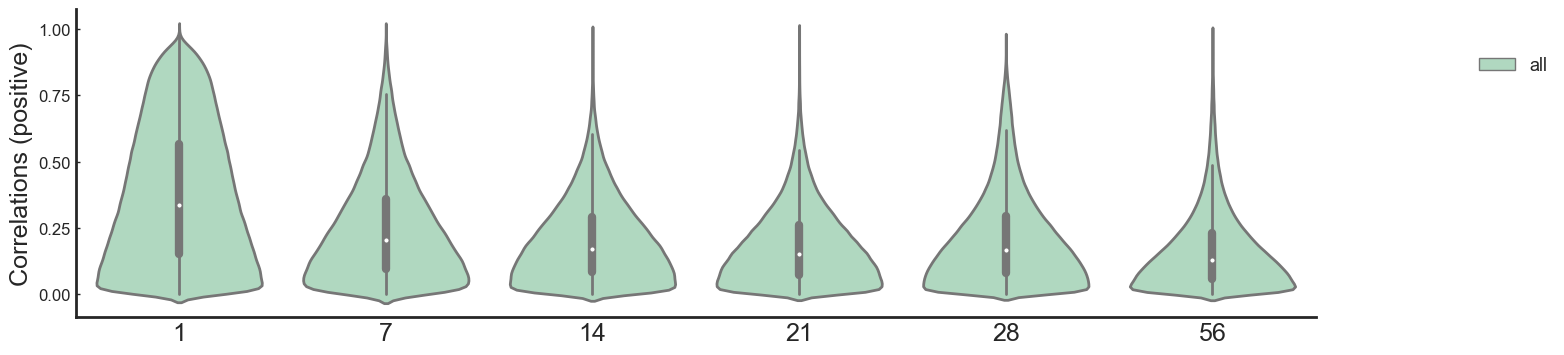

------- d1 vs d7 --------
ks_2samp stat: 0.2218032185918497  p value: 0.0
------- d1 vs d14 --------
ks_2samp stat: 0.315905748961839  p value: 0.0
------- d1 vs d21 --------
ks_2samp stat: 0.35809883451004004  p value: 0.0
------- d1 vs d28 --------
ks_2samp stat: 0.3028848067933565  p value: 0.0
------- d1 vs d56 --------
ks_2samp stat: 0.3938836101577527  p value: 0.0
------- d7 vs d14 --------
ks_2samp stat: 0.09643683084176435  p value: 0.0
------- d7 vs d21 --------
ks_2samp stat: 0.14431986258854523  p value: 0.0
------- d7 vs d28 --------
ks_2samp stat: 0.09152937083858825  p value: 0.0
------- d7 vs d56 --------
ks_2samp stat: 0.19978239160434086  p value: 0.0
------- d14 vs d21 --------
ks_2samp stat: 0.05433434830585593  p value: 0.0
------- d14 vs d28 --------
ks_2samp stat: 0.028514323459564284  p value: 5.982246238562656e-160
------- d14 vs d56 --------
ks_2samp stat: 0.125233802091326  p value: 0.0
------- d21 vs d28 --------
ks_2samp stat: 0.05544552106582756  p value: 

In [22]:
mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]
day_names = ["D1", "D7", "D14", "D21", "D28","D56"]
colors_light = ["#a9dfbf"]

''' correlation distribution '''

active_num_dict = {}
for day in day_selected:
    active_num_dict[day] = []

# load data
for mouse in mice_ids:
    day_info_list = day_info_dict[mouse]
    for day_info in day_info_list:
        day = int(day_info.split('d')[1])
        if day not in day_selected:
            continue
        day_data = []
        data = np.load(res_path + str(mouse) + "/res_angle_stable_neurons_corr_pos_list" + day_info + "_dict.npy", allow_pickle = True).item()
        for angle in [0]:
            day_data.extend(data[angle])
        active_num_dict[day].extend(day_data)
        
x, hue, data_flatten = [], [], []
for day in day_selected:
    x.extend(len(active_num_dict[day]) * [day])
    data_flatten.extend(active_num_dict[day])
    hue.extend(len(active_num_dict[day]) * ["all"])

## data and labels
fig,ax = plt.subplots(figsize=(16,4),dpi=100,facecolor="w")
ax = plt.subplot(1, 1, 1)
sns.violinplot(x = x, y = data_flatten, hue = hue, order = day_selected, ax = ax, palette = colors_light,
                    width = 0.8, linewidth = 2, notch = False, alpha =1)
ax.legend(bbox_to_anchor=(1.2,0.9), fontsize = 13)
ax.tick_params(which='major',direction='in',length=3,width=1.,labelsize=20,bottom=False)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_axisbelow(True)
ax.set_ylabel("Correlations (positive)", fontsize = 18)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 18)
plt.savefig(save_path + "fig6_corr_positive_dist_violin.pdf", dpi = 300, bbox_inches='tight')
plt.show()

### test
p_list = []
pairs = []
for i in range(len(day_selected) - 1):
    pair1 = day_selected[i]
    for j in range(i + 1, len(day_selected)):
        pair2 = day_selected[j]
        pairs.append((pair1, pair2))
        
        print("------- d%d vs d%d --------" % (pair1, pair2))
        data1, data2 = active_num_dict[pair1], active_num_dict[pair2]
        stat, p_vlaue = stats.ks_2samp(data1, data2, alternative='two-sided', mode="auto")
        print("ks_2samp stat:", stat, " p value:", p_vlaue)
        p_list.append(p_vlaue)

n = 3
print("---- p_list:", p_list)
ps = [round(i/n, 4) for i in p_list]
print("---- ps:", ps)
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("---- p_adj:", [round(i,4) for i in ps_adj])
print("---- pairs:", pairs)

## 07-1 Neuron-level correlation matrix

### neurons clustering

0 (724, 724) 724


D:\Program_Files\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


similarity_hie: (724, 724)
similarity_sample: (200, 200)


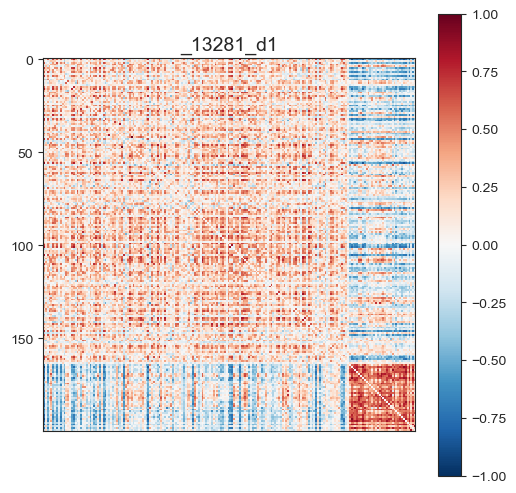

0 (265, 265) 265


D:\Program_Files\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


similarity_hie: (265, 265)
similarity_sample: (200, 200)


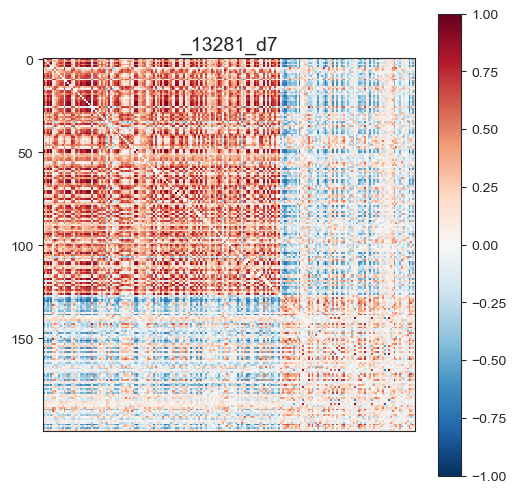

0 (208, 208) 208
similarity_hie: (208, 208)


D:\Program_Files\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


similarity_sample: (200, 200)


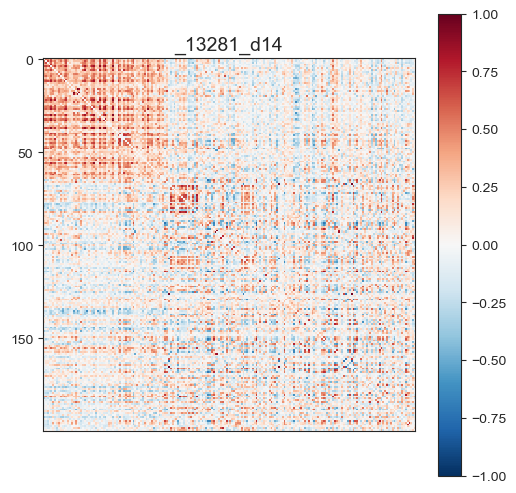

0 (772, 772) 772


D:\Program_Files\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


similarity_hie: (772, 772)
similarity_sample: (200, 200)


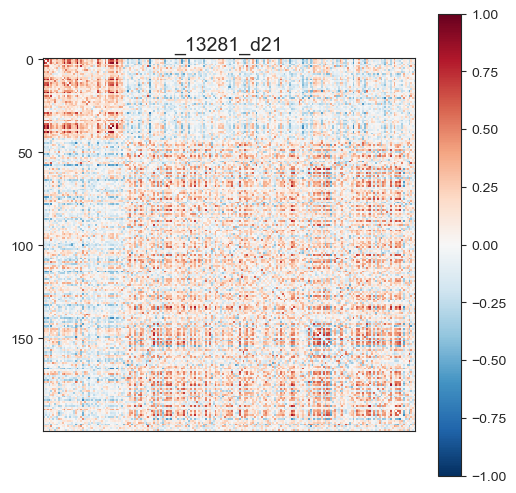

0 (1145, 1145) 1145


D:\Program_Files\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


similarity_hie: (1145, 1145)
similarity_sample: (200, 200)


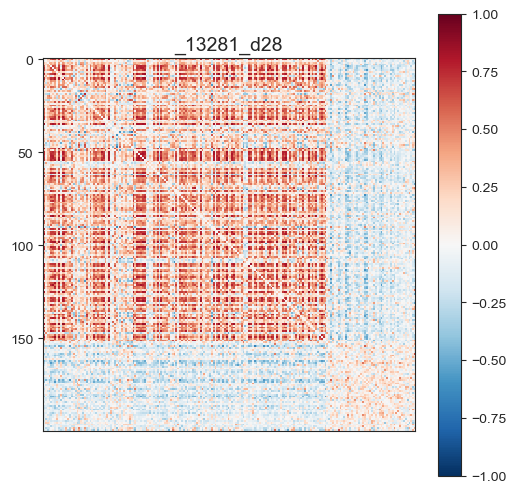

In [60]:
''' corr clustering '''

from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]
mouse_colors = ["#76448a", "#1f618d", "#1e8449"]
angles = [0, 45, 90, 135]

''' neuron matrix clustering '''

mou_idx = 2
mouse = mice_ids[mou_idx]
color = mouse_colors[mou_idx]
day_info_list = day_info_dict[mouse]

sample_n = 200
angle = 0
k = 2
for day_info in day_info_list:
    day = int(day_info.split('d')[1])
    if day not in day_selected:
        continue
        
    similarity_dict = np.load(res_path + str(mouse) + "/res_angle_stable_neurons_corr_matrix" + day_info + "_dict.npy", allow_pickle = True).item()
    neuron_ids_dict = np.load(res_path + str(mouse) + "/res_angle_stable_neurons_corr_neuron_ids" + day_info + "_dict.npy", allow_pickle = True).item()

    similarity = similarity_dict[angle]
    select_ids = neuron_ids_dict[angle]
    print(angle, similarity.shape, len(select_ids))
        
    ''' clustering '''
    spectral_cluster = SpectralClustering(n_clusters = k) #KMeans(n_clusters = k)
    clusters = spectral_cluster.fit_predict(similarity)
    clusters = [i + 1 for i in clusters]

    # sorted ids
    hierarchy_idx_fla = []
    for index_id in range(1,k + 1):
        index = [i for i,j in enumerate(clusters) if j == index_id]
        hierarchy_idx_fla.extend(index)

    # calculate cluster correlation
    similarity_hie = np.zeros(similarity.shape)
    n_neuron = len(select_ids)
    for i in range(n_neuron - 1):
        for j in range(i + 1, n_neuron):   
            x, y = hierarchy_idx_fla[i],hierarchy_idx_fla[j]
            similarity_hie[i,j] = similarity_hie[j,i] = similarity[x,y]
    print("similarity_hie:", similarity_hie.shape)
    
    # sample
    sample_ids = random.sample(range(len(similarity_hie)), sample_n)
    sample_ids.sort()
    similarity_sample = np.zeros((sample_n, sample_n))
    for i in range(sample_n):
        for j in range(i, sample_n):
            x, y = sample_ids[i],sample_ids[j]
            similarity_sample[i,j] = similarity_sample[j,i] = similarity_hie[x,y]
    print("similarity_sample:", similarity_sample.shape)
    
    # plot
    fig,ax = plt.subplots(figsize=(6,6),dpi=100,facecolor="w")
    ax = plt.subplot(1,1,1)
    caxes = ax.matshow(similarity_sample, interpolation ='nearest',cmap = 'RdBu_r', vmax = 1, vmin = -1)
    plt.title(day_info, fontsize = 14)
    fig.colorbar(caxes) 
    plt.xticks([])
    plt.savefig(save_path + "fig6_corr_neuron_matrix" + day_info + ".pdf", dpi = 300, bbox_inches='tight')
    plt.show()

        

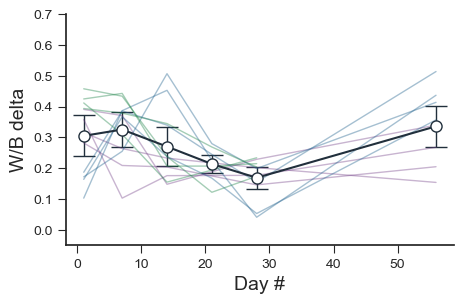

------- d1 vs d7 --------
Wilcoxon stat: 38.0  p value: 0.9697265625
------- d1 vs d14 --------
Wilcoxon stat: 30.0  p value: 0.5185546875
------- d1 vs d21 --------
mannwhitneyu stat: 69.0  p value: 0.11526553941414623
------- d1 vs d28 --------
Wilcoxon stat: 1.0  p value: 0.0009765625
------- d1 vs d56 --------
mannwhitneyu stat: 42.0  p value: 0.6784313725490196
------- d7 vs d14 --------
Wilcoxon stat: 23.0  p value: 0.2333984375
------- d7 vs d21 --------
mannwhitneyu stat: 80.0  p value: 0.012399777724855125
------- d7 vs d28 --------
Wilcoxon stat: 4.0  p value: 0.00341796875
------- d7 vs d56 --------
mannwhitneyu stat: 47.0  p value: 0.9699293482575216
------- d14 vs d21 --------
mannwhitneyu stat: 57.5  p value: 0.4871256543629552
------- d14 vs d28 --------
Wilcoxon stat: 16.0  p value: 0.0771484375
------- d14 vs d56 --------
mannwhitneyu stat: 32.5  p value: 0.24680436315226406
------- d21 vs d28 --------
mannwhitneyu stat: 67.0  p value: 0.1568627450980392
------- d21 vs

In [26]:
mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]
mouse_colors = ["#76448a", "#1f618d", "#1e8449"]
angles = [0, 45, 90, 135]

''' delta of seperate angles '''

active_num_dict = {}
for day in day_selected:
    active_num_dict[day] = []

x_list, number_list, color_list = [], [], []
for mou_idx in range(len(mice_ids)):
    mouse = mice_ids[mou_idx]
    color = mouse_colors[mou_idx]
    day_info_list = day_info_dict[mouse]
    
    active_num = {}
    for angle in [0, 45, 90, 135]:
        active_num[angle] = []
    day_list = []
    for day_info in day_info_list:
        day = int(day_info.split('d')[1])
        if day not in day_selected:
            continue
        day_list.append(day)
        data = np.load(res_path + str(mouse) + "/res_stable_neurons_corr_cluster_wb_delta" + day_info + "_list.npy")
        for angle_i in range(len(angles)):
            angle = angles[angle_i]
            active_num[angle].append(data[angle_i])
    angle_avg_list = []
    for angle in [0, 45, 90, 135]:
        avg_list = [np.mean(i) for i in active_num[angle]]
        angle_avg_list.append(avg_list)
    
    x_list.append(day_list)
    number_list.append(angle_avg_list)
    color_list.append(color)
    
    angle_avg_list = np.array(angle_avg_list)
    for day_idx in range(len(day_list)):
        day = day_list[day_idx]
        active_num_dict[day].extend(angle_avg_list[:, day_idx])


# avg
active_num_avg, active_num_std = [], []
for day in day_selected:
    active_num_avg.append(np.mean(active_num_dict[day]))
    active_num_std.append(np.std(active_num_dict[day]))

# line plot
fig,ax = plt.subplots(figsize=(5,3),dpi=100,facecolor="w")
active_num_std = [i / np.sqrt(len(mice_ids)) for i in active_num_std]
plt.errorbar(day_selected, active_num_avg, yerr = active_num_std, fmt = 'o-', ecolor = "#212f3c",  elinewidth = 1, 
        capthick = 1, color = "#212f3c", capsize = 8, ms = 8, mfc = 'w', alpha = 1)
x, y = [], []
for i in range(len(x_list)):
    for valus in number_list[i]:
        plt.plot(x_list[i], valus, "-", color = color_list[i], linewidth = 1, alpha = 0.4)
        x.extend(x_list[i])
        y.extend(valus)
plt.xlabel("Day #", fontsize = 14)
plt.ylabel("W/B delta", fontsize = 14)
plt.ylim(-0.05, 0.7)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
plt.savefig(save_path + "fig6_module_wb_delta.pdf", dpi = 300, bbox_inches='tight')
plt.show()

## save data
data_save = [day_selected, active_num_avg, active_num_std]
np.save(save_path + 'fig6_module_wb_delta_line.npy', data_save)
data_save = [x, y]
np.save(save_path + 'fig6_module_wb_delta_line_single.npy', data_save)

data_csv = pd.DataFrame({"day":day_selected, "avg":active_num_avg, "std":active_num_std})
data_csv.to_csv(save_path + 'fig6_module_wb_delta_line.csv', sep = ",")
data_csv = pd.DataFrame({"x":x, "y":y,})
data_csv.to_csv(save_path + 'fig6_module_wb_delta_line_single.csv', sep = ",")

### test
p_list = []
pairs = []
for i in range(len(day_selected) - 1):
    pair1 = day_selected[i]
    for j in range(i + 1, len(day_selected)):
        pair2 = day_selected[j]
        pairs.append((pair1, pair2))
        
        print("------- d%d vs d%d --------" % (pair1, pair2))
        data1, data2 = active_num_dict[pair1], active_num_dict[pair2]
        if len(data1) ==  len(data2):
            stat, p_vlaue = stats.wilcoxon(data1, data2, alternative='two-sided', correction = True)
            print("Wilcoxon stat:", stat, " p value:", p_vlaue)
            p_list.append(p_vlaue)
        else:
            stat, p_vlaue = stats.mannwhitneyu(data1, data2, alternative='two-sided')
            print("mannwhitneyu stat:", stat, " p value:", p_vlaue)
            p_list.append(p_vlaue)

n = 3
print("---- p_list:", p_list)
ps = [round(i/n, 4) for i in p_list]
print("---- ps:", ps)
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("---- p_adj:", [round(i,4) for i in ps_adj])
print("---- pairs:", pairs)

## 07-2 Region-level correlation matrix

### matrix

acs_all: 35 acs_all_set: 11
similarity: (24, 24) acs_all_overlap: 24
similarity_new: (11, 11)


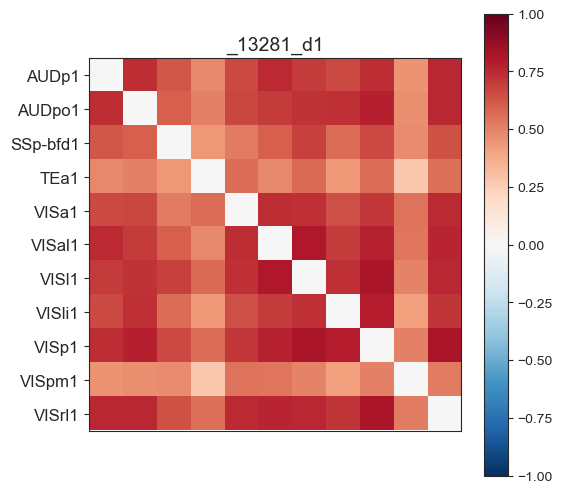

similarity: (21, 21) acs_all_overlap: 21
similarity_new: (11, 11)


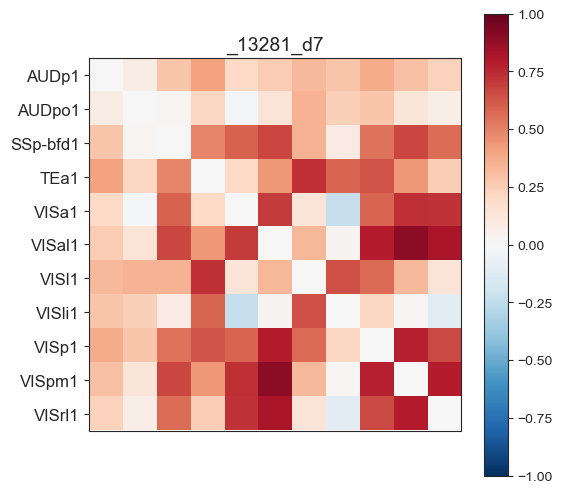

similarity: (23, 23) acs_all_overlap: 23
similarity_new: (11, 11)


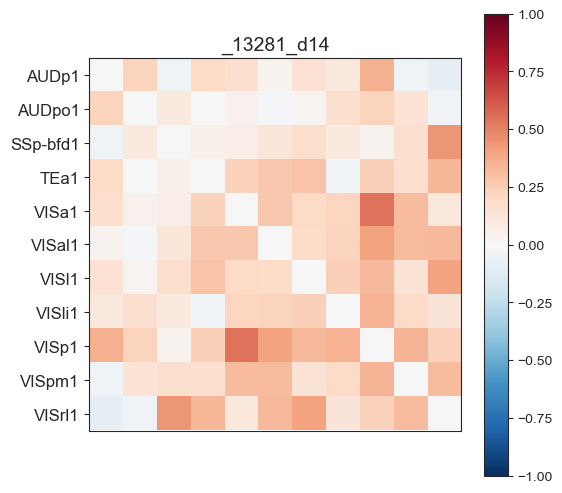

similarity: (22, 22) acs_all_overlap: 22
similarity_new: (11, 11)


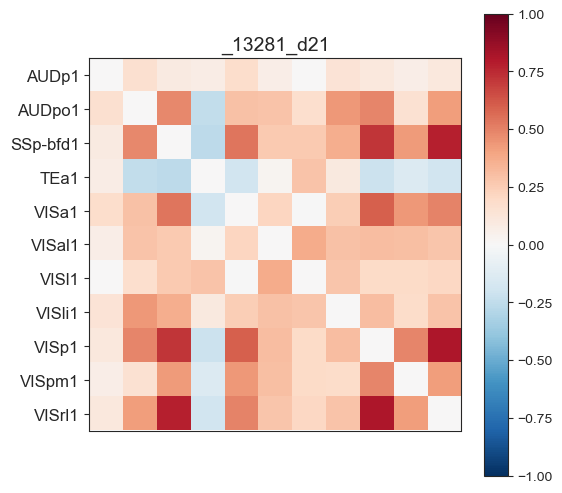

similarity: (21, 21) acs_all_overlap: 21
similarity_new: (11, 11)


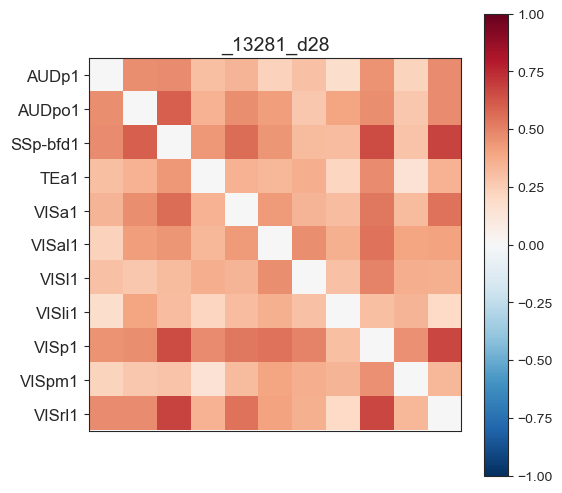

In [59]:
from sklearn.cluster import KMeans

mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]
mouse_colors = ["#76448a", "#1f618d", "#1e8449"]
angles = [0, 45, 90, 135]

''' modularity - matrix clustering '''

mou_idx = 2
mouse = mice_ids[mou_idx]
color = mouse_colors[mou_idx]
day_info_list = day_info_dict[mouse]
    
''' plot corr matrix - same sort '''
acs_all = {}
for day_info in day_info_list:
    day = int(day_info.split('d')[1])
    if day not in day_selected:
        continue
    acs_all_overlap = np.load(res_path + str(mouse) + "/res_angle_region_corr_acs_avg" + day_info + ".npy").tolist() 
    for i in acs_all_overlap:
        if i in acs_all:
            acs_all[i] += 1
        else:
            acs_all[i] = 1
acs_all_set = []
for k,v in acs_all.items():
    if v < len(day_info_list):
        continue
    acs_all_set.append(k)
acs_all_set.sort()

for day_info in day_info_list:
    day = int(day_info.split('d')[1])
    if day not in day_selected:
        continue
    similarity = np.load(res_path + str(mouse) + "/res_angle_region_corr_matrix_avg" + day_info + ".npy")
    acs_all_overlap = np.load(res_path + str(mouse) + "/res_angle_region_corr_acs_avg" + day_info + ".npy").tolist()
    
    n_acs_all_set = len(acs_all_set)
    similarity_new = np.zeros((n_acs_all_set, n_acs_all_set))
    for i in range(n_acs_all_set - 1):
        for j in range(i + 1, n_acs_all_set):
            x, y = acs_all_overlap.index(acs_all_set[i]), acs_all_overlap.index(acs_all_set[j])
            similarity_new[i,j] = similarity_new[j,i] = similarity[x,y]
    
    # plot
    fig,ax = plt.subplots(figsize=(6,6),dpi=100,facecolor="w")
    ax = plt.subplot(1,1,1)
    caxes = ax.matshow(similarity_new, interpolation ='nearest',cmap = 'RdBu_r', vmax = 1, vmin = -1)
    plt.title(day_info, fontsize = 14)
    fig.colorbar(caxes) 
    plt.yticks(range(len(acs_all_set)), acs_all_set, fontsize = 12, rotation = 0)
    plt.xticks([])
    plt.savefig(save_path + "fig6_corr_region_matrix_overlap" + day_info + ".pdf", dpi = 300, bbox_inches='tight')
    plt.show()

### node centrality

D:\Program_Files\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Program_Files\anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Program_Files\anaconda3\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\Program_Files\anaconda3\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
D:\Program_Files\anaconda3\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is cal

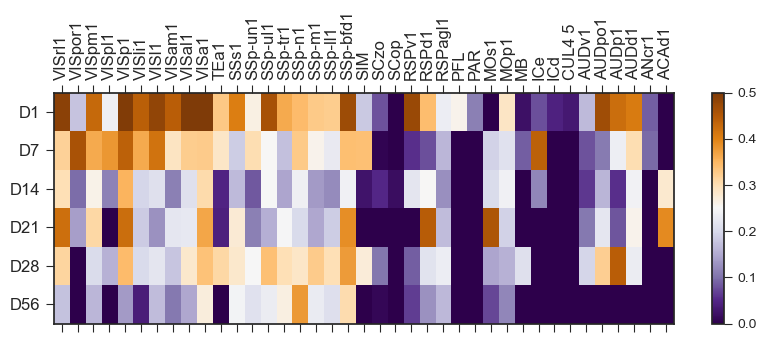

In [25]:
mice_ids = [13124, 13141, 13281]
day_selected = [1,7,14,21,28,56]
day_colors = ["#76448a", "#1f618d", "#1e8449", "#b9770e", "#ba4a00", "#5d6d7e"]
angles = [0, 45, 90, 135]

''' closeness centrality '''
acs_all_overlap_all = []
for mou_idx in range(len(mice_ids)):
    mouse = mice_ids[mou_idx]
    day_info_list = day_info_dict[mouse]
    for day_info in day_info_list:
        day = int(day_info.split('d')[1])
        if day not in day_selected:
            continue
        acs_all_overlap = np.load(res_path + str(mouse) + "/res_angle_region_corr_acs_avg" + day_info + ".npy")
        acs_all_overlap_all.extend(acs_all_overlap)
acs_all_overlap_all = list(set(acs_all_overlap_all))
acs_all_overlap_all =  [i for i in acs_all_overlap_all if i not in ["root", "bic"]]
acs_all_overlap_all.sort()
acs_all_overlap_all.reverse()

avg_list, std_list = [], []
for day in day_selected:
    values_region_dict = {}
    for reg in acs_all_overlap_all:
        values_region_dict[reg] = []
    
    for mou_idx in range(len(mice_ids)):
        mouse = mice_ids[mou_idx]
        day_info = "_" + str(mouse) + "_d" + str(day)
        if day_info not in day_info_dict[mouse]:
            continue
        data = np.load(res_path + str(mouse) + "/res_angle_region_corr_closeness_central" + day_info + "_dict.npy", allow_pickle = True).item()
        for reg, values in data.items():
            if reg not in values_region_dict:
                continue
            values_region_dict[reg].extend(values)
            
    # avg
    active_num_avg, active_num_std = [], []
    for reg in acs_all_overlap_all:
        active_num_avg.append(np.mean(values_region_dict[reg]))
        active_num_std.append(np.std(values_region_dict[reg]))
    avg_list.append(active_num_avg)
    std_list.append(active_num_std)

# plot
avg_list = np.nan_to_num(avg_list)
fig,ax = plt.subplots(figsize=(10,3),dpi=100,facecolor="w")
ax = plt.subplot(1,1,1)
caxes = ax.matshow(avg_list, interpolation ='nearest',cmap = 'PuOr_r', vmax = 0.5, vmin = 0, aspect = "auto")
fig.colorbar(caxes) 
plt.xticks(range(len(acs_all_overlap_all)), acs_all_overlap_all, fontsize = 12, rotation = 90)
plt.yticks(range(len(day_selected_name)), day_selected_name, fontsize = 12)
plt.legend()
plt.savefig(save_path + "fig6_network_close_centrality.pdf", dpi = 300, bbox_inches='tight')
plt.show()